In [35]:
# !pip install liac-arff

In [36]:
import pandas as pd
import numpy as np
import random
import torch
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import arff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

In [37]:
# 1. Load the dataset from ARFF format
file_path = '/home/naamamai/adult.arff'
with open(file_path, 'r') as f:
    arff_data = arff.load(f)

# 2. Extract attribute names (column headers) and data
attribute_names = [attr[0] for attr in arff_data['attributes']]
data = arff_data['data']

# 3. Create a DataFrame
df = pd.DataFrame(data, columns=attribute_names)

# Print the first few rows
print("First 5 rows of the DataFrame:")
print(df.head())

First 5 rows of the DataFrame:
    age         workclass    fnlwgt  education  education-num  \
0  39.0         State-gov   77516.0  Bachelors           13.0   
1  50.0  Self-emp-not-inc   83311.0  Bachelors           13.0   
2  38.0           Private  215646.0    HS-grad            9.0   
3  53.0           Private  234721.0       11th            7.0   
4  28.0           Private  338409.0  Bachelors           13.0   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0        2174.0           0.0            40.0  United-States  <

In [38]:
# Check unique values in the target column "income"
print("\nUnique Values in the 'income' Column:")
print(df['income'].unique())

# Identify continuous vs. categorical by data type
# (Alternatively, you may have a predefined schema from the ARFF header.)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)


# Print shape of the dataset
print("\nDataset Shape (rows, columns):", df.shape)

# Target label check
print("\nTarget Label Distribution (income):")
print(df['income'].value_counts())


Unique Values in the 'income' Column:
['<=50K' '>50K']

Numeric Columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical Columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

Dataset Shape (rows, columns): (32561, 15)

Target Label Distribution (income):
income
<=50K    24720
>50K      7841
Name: count, dtype: int64


In [39]:
def stratified_train_test_splits(df: pd.DataFrame, label_col: str = 'income',
                                 test_size: float = 0.2, n_splits: int = 3):
    """
    Performs a stratified train-test split of the DataFrame multiple times (n_splits).
    Ensures the label distribution is maintained. Returns a list of (X_train, X_test, y_train, y_test).
    """
    # Separate features and labels
    X = df.drop(columns=[label_col])
    y = df[label_col]

    # Encode label if needed (<=50K, >50K -> 0, 1)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # We will hold results from each split
    splits_data = []

    # we can define our own random seeds
    random_seeds = [1,2,3]

    for i, seed in enumerate(random_seeds[:n_splits]):
        # Fix the random seed for reproducibility
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)

        for train_index, test_index in sss.split(X, y_encoded):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y_encoded[train_index], y_encoded[test_index]

            splits_data.append((X_train, X_test, y_train, y_test))

            # Print a small summary
            print(f"\n=== Split {i+1} / Random State {seed} ===")
            print(f"Train size: {len(train_index)} | Test size: {len(test_index)}")

            # Check label distribution in train/test
            train_0 = sum(y_train == 0)
            train_1 = sum(y_train == 1)
            test_0 = sum(y_test == 0)
            test_1 = sum(y_test == 1)

            print(f"Train distribution: 0 -> {train_0}, 1 -> {train_1}")
            print(f"Test distribution:  0 -> {test_0},  1 -> {test_1}")

    return splits_data, label_encoder


Stratification: Each split shows the same label distribution in both train and test (0 -> ~76%, 1 -> ~24%), reflecting the original distribution of <=50K and >50K. Stratified splitting ensures the label proportions are maintained.

In [40]:
# 1.2 Train-Test Split (repeated 3 times)
splits, label_enc = stratified_train_test_splits(df, label_col='income',test_size=0.2, n_splits=3)

# Each element in `splits` is a tuple (X_train, X_test, y_train, y_test).
X_train_1, X_test_1, y_train_1, y_test_1 = splits[0]
X_train_2, X_test_2, y_train_2, y_test_2 = splits[1]
X_train_3, X_test_3, y_train_3, y_test_3 = splits[2]


=== Split 1 / Random State 1 ===
Train size: 26048 | Test size: 6513
Train distribution: 0 -> 19775, 1 -> 6273
Test distribution:  0 -> 4945,  1 -> 1568

=== Split 2 / Random State 2 ===
Train size: 26048 | Test size: 6513
Train distribution: 0 -> 19775, 1 -> 6273
Test distribution:  0 -> 4945,  1 -> 1568

=== Split 3 / Random State 3 ===
Train size: 26048 | Test size: 6513
Train distribution: 0 -> 19775, 1 -> 6273
Test distribution:  0 -> 4945,  1 -> 1568


In [41]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, data_dim, embed_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(data_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout layer with a rate of 0.2
            nn.Linear(128, embed_dim),  # Latent embedding dimension
            nn.BatchNorm1d(embed_dim)  # Add BatchNorm after the encoding layer
        )
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout layer
            nn.Linear(128, data_dim),
            nn.Sigmoid()  # Output normalized values
        )

    def forward(self, x):
        embedding = self.encoder(x)
        reconstructed = self.decoder(embedding)
        return embedding, reconstructed


# Define GAN components
class Generator(nn.Module):
    def __init__(self, noise_dim, embed_dim, hidden_dim=128):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # Batch Normalization
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),  # Add dropout layer
            nn.Linear(hidden_dim, embed_dim)
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, data_dim, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),  # Batch Normalization
            nn.Dropout(0.2),  # Add dropout layer
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)


# Define Dataset class
class Dataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float() if isinstance(X, np.ndarray) else X.float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]


In [42]:
# Train GAN with Autoencoder
def train_gan_autoencoder(X_train_preprocessed, noise_dim, embed_dim, num_epochs, batch_size, device, seed, gen_lr, disc_lr):
    # Fix the random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    data_dim = X_train_preprocessed.shape[1]
    train_dataset = Dataset(X_train_preprocessed)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize models
    autoencoder = Autoencoder(data_dim, embed_dim).to(device)
    generator = Generator(noise_dim, embed_dim).to(device)
    discriminator = Discriminator(data_dim).to(device)

    # Optimizers with custom learning rates
    ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=gen_lr)  # Autoencoder generator optimizer
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=gen_lr)  # Generator optimizer
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=disc_lr)  # Discriminator optimizer

    # Losses
    reconstruction_loss_fn = nn.MSELoss()
    gan_loss_fn = nn.BCEWithLogitsLoss()


    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    gen_losses_epoch, disc_losses_epoch, ae_losses_epoch = [], [], []

    for epoch in range(num_epochs):
        autoencoder.train()
        generator.train()
        discriminator.train()

        running_gen_loss, running_disc_loss, running_ae_loss = 0.0, 0.0, 0.0
        num_batches = 0

        for step, real_samples in enumerate(loader):
            num_batches += 1
            real_samples = real_samples.to(device)
            batch_size = real_samples.size(0)

            # -------------------------
            # Step 1: Train Autoencoder
            # -------------------------
            _, reconstructed = autoencoder(real_samples)
            ae_loss = reconstruction_loss_fn(reconstructed, real_samples)
            ae_optimizer.zero_grad()
            ae_loss.backward()
            ae_optimizer.step()

            # -------------------------
            # Step 2: Train Discriminator
            # -------------------------

            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            noise = torch.randn((batch_size, noise_dim), device=device)
            fake_embeddings = generator(noise)
            fake_samples = autoencoder.decoder(fake_embeddings)

            disc_real_output = discriminator(real_samples)
            disc_fake_output = discriminator(fake_samples.detach())
            disc_loss_real = gan_loss_fn(disc_real_output, torch.ones_like(disc_real_output))
            disc_loss_fake = gan_loss_fn(disc_fake_output, torch.zeros_like(disc_fake_output))
            disc_loss = disc_loss_real + disc_loss_fake

            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()

            # -------------------------
            # Step 3: Train Generator
            # -------------------------

            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            
            noise = torch.randn((batch_size, noise_dim), device=device)
            fake_embeddings = generator(noise)
            fake_samples = autoencoder.decoder(fake_embeddings)
            disc_fake_output = discriminator(fake_samples)
            gen_loss = gan_loss_fn(disc_fake_output, torch.ones_like(disc_fake_output))

            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            # Accumulate losses
            running_ae_loss += ae_loss.item()
            running_gen_loss += gen_loss.item()
            running_disc_loss += disc_loss.item()

            # Intermediate print at every 50 steps
            if step % 50 == 0:
                print(f"Epoch: {epoch + 1} Step: {step} "
                      f"Gen Loss: {gen_loss.item():.4f} "
                      f"Disc Fake Loss: {disc_loss_fake.item():.4f} "
                      f"Disc Real Loss: {disc_loss_real.item():.4f} "
                      f"Disc Total Loss: {disc_loss.item():.4f} "
                      f"AE Loss: {ae_loss.item():.4f}")

        # Track epoch losses
        ae_losses_epoch.append(running_ae_loss / num_batches)
        gen_losses_epoch.append(running_gen_loss / num_batches)
        disc_losses_epoch.append(running_disc_loss / num_batches)

        # Epoch-end print
        print(f"Epoch: {epoch + 1} Step: 0 "
              f"Gen Loss: {running_gen_loss / num_batches:.4f} "
              f"Disc Total Loss: {running_disc_loss / num_batches:.4f} "
              f"AE Loss: {running_ae_loss / num_batches:.4f}")

    return autoencoder, generator, ae_losses_epoch, gen_losses_epoch, disc_losses_epoch


In [43]:
# Function to evaluate detection metric using AUC (for real and synthetic data)
def detection_metric(real_data, synthetic_data,seed, n_folds=4):
    """
    Evaluate the similarity between real and synthetic data using a Random Forest classifier.
    Train the classifier on a 50-50 mix of real and synthetic data, evaluate it using stratified k-fold cross-validation.

    Parameters:
    - real_data: ndarray of shape (N, D), real data (80% of the training set, preprocessed).
    - synthetic_data: ndarray of shape (N, D), synthetic data (same size as real_data).
    - n_folds: int, number of folds for stratified k-fold.
    - seed: int, random seed for reproducibility.

    Returns:
    - average_auc: float, average AUC score across folds.
    """
    # Fix the random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 1. Combine real and synthetic data into a single dataset
    combined_data = np.vstack([real_data, synthetic_data])
    combined_labels = np.hstack([
        np.ones(real_data.shape[0]),  # Label 1 for real data
        np.zeros(synthetic_data.shape[0])  # Label 0 for synthetic data
    ])

    # 2. Initialize stratified k-fold cross-validator
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    aucs = []

    # 3. Perform stratified k-fold cross-validation
    for train_index, test_index in skf.split(combined_data, combined_labels):
        # Split into training and testing datasets
        X_train, X_test = combined_data[train_index], combined_data[test_index]
        y_train, y_test = combined_labels[train_index], combined_labels[test_index]

        # Train a Random Forest classifier
        clf = RandomForestClassifier(n_estimators=100, random_state=seed)
        clf.fit(X_train, y_train)

        # Predict probabilities for the test set
        y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of being real
        auc = roc_auc_score(y_test, y_prob)
        aucs.append(auc)

    # 4. Compute and return the average AUC across all folds
    average_auc = np.mean(aucs)
    return average_auc

# Function to evaluate efficacy metric
def efficacy_metric(X_train_real, y_train_real, X_test_real, y_test_real, X_train_synth, seed):
    """
    Computes the efficacy metric for synthetic data.

    Steps:
    i. Train a Random Forest model on the real training set and test it on the real test set.
    ii. Train a Random Forest model on the synthetic data and test it on the real test set.
    iii. Compute the ratio of the synthetic-to-real AUC scores.

    Returns:
        - AUC score for real->real
        - AUC score for synthetic->real
        - Efficacy ratio (synthetic AUC / real AUC)
    """
    # Fix the random seed for reproducibility
    random.seed(seed)  # For Python's random module
    np.random.seed(seed)  # For numpy random functions
    torch.manual_seed(seed)  # For PyTorch random functions (if used)
    torch.cuda.manual_seed_all(seed)


    # i. Train on Real -> Test on Real
    clf_real = RandomForestClassifier(n_estimators=100, random_state=seed)
    clf_real.fit(X_train_real, y_train_real)
    y_prob_real = clf_real.predict_proba(X_test_real)[:, 1]
    auc_real = roc_auc_score(y_test_real, y_prob_real)

    # ii. Train on Synthetic -> Test on Real
    clf_synth = RandomForestClassifier(n_estimators=100, random_state=seed)
    clf_synth.fit(X_train_synth, y_train_real)
    y_prob_synth = clf_synth.predict_proba(X_test_real)[:, 1]
    auc_synth = roc_auc_score(y_test_real, y_prob_synth)

    # iii. Compute efficacy ratio
    ratio = auc_synth / auc_real
    return auc_real, auc_synth, ratio


first seed = 1

In [44]:
seed = 1

In [45]:
# Define which columns are continuous vs. categorical
continuous_features = ['age', 'fnlwgt', 'education-num',
                       'capital-gain', 'capital-loss', 'hours-per-week']

categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'sex',
                        'native-country']

# --- 1. Scale continuous features using MinMaxScaler ---
# Fit the scaler on the original (unnormalized) continuous data
scaler = MinMaxScaler()

scaler.fit(X_train_1[continuous_features])  # Fit on the original data

X_train_cont_scaled = scaler.transform(X_train_1[continuous_features])
X_test_cont_scaled = scaler.transform(X_test_1[continuous_features])

# --- 2. Encode categorical features using OneHotEncoder ---
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat_encoded = oh_encoder.fit_transform(X_train_1[categorical_features])
X_test_cat_encoded = oh_encoder.transform(X_test_1[categorical_features])

# --- 3. Combine scaled continuous features and one-hot categorical features ---
X_train_preprocessed = np.hstack([X_train_cont_scaled, X_train_cat_encoded])
X_test_preprocessed = np.hstack([X_test_cont_scaled, X_test_cat_encoded])

# Print the shapes to verify
print("Shapes after preprocessing:")
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("X_test_preprocessed  shape:", X_test_preprocessed.shape)


Shapes after preprocessing:
X_train_preprocessed shape: (26048, 108)
X_test_preprocessed  shape: (6513, 108)


In [46]:
# Fixed parameters
gen_lr = 0.0001  # Generator learning rate
disc_lr = 0.00001  # Discriminator learning rate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 32  # Size of the latent embedding space

# Parameters for the experiments
batch_sizes = [128, 256, 512]
num_epochs_list = [30, 50]
noise_dims = [100, 200]

# Placeholder for results
results = []

# Perform experiments
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for noise_dim in noise_dims:
            # Train the models
            autoencoder, generator, ae_losses, gen_losses, disc_losses = train_gan_autoencoder(
                X_train_preprocessed, noise_dim, embed_dim=embed_dim, num_epochs=num_epochs, batch_size=batch_size,
                device=device, seed=seed, gen_lr=gen_lr, disc_lr=disc_lr
            )

            # Generate synthetic data
            num_synthetic_samples = X_train_preprocessed.shape[0]
            # Fix the random seed for reproducibility
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            noise = torch.randn((num_synthetic_samples, noise_dim), device=device)
            with torch.no_grad():
                synthetic_embeddings = generator(noise)
                synthetic_data_tensor = autoencoder.decoder(synthetic_embeddings)
            synthetic_data = synthetic_data_tensor.cpu().numpy()

            # Calculate metrics
            auc_real, auc_synth, efficacy_ratio = efficacy_metric(
                X_train_preprocessed, y_train_1, X_test_preprocessed, y_test_1, synthetic_data, seed
            )

            real_data_80 = X_train_preprocessed[:int(0.8 * X_train_preprocessed.shape[0])]
            synthetic_data_80 = synthetic_data[:real_data_80.shape[0]]
            detection_auc = detection_metric(real_data_80, synthetic_data_80, seed)

            # Append results to the list
            results.append({
                "Batch Size": batch_size,
                "Num Epochs": num_epochs,
                "Noise Dim": noise_dim,
                "Real->Real AUC": auc_real,
                "Synthetic->Real AUC": auc_synth,
                "Efficacy Ratio": efficacy_ratio,
                "Detection AUC": detection_auc
            })

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Display the results
def display_results(df):
    print(df.head())  # Replace with an actual visualization or export logic if needed

# Display or return the results DataFrame
display_results(results_df)


Epoch: 1 Step: 0 Gen Loss: 0.7597 Disc Fake Loss: 0.6334 Disc Real Loss: 0.7709 Disc Total Loss: 1.4043 AE Loss: 0.2520
Epoch: 1 Step: 50 Gen Loss: 0.6741 Disc Fake Loss: 0.6504 Disc Real Loss: 0.7534 Disc Total Loss: 1.4037 AE Loss: 0.2147
Epoch: 1 Step: 100 Gen Loss: 0.6211 Disc Fake Loss: 0.6642 Disc Real Loss: 0.7235 Disc Total Loss: 1.3877 AE Loss: 0.1758
Epoch: 1 Step: 150 Gen Loss: 0.5867 Disc Fake Loss: 0.6718 Disc Real Loss: 0.7237 Disc Total Loss: 1.3955 AE Loss: 0.1268
Epoch: 1 Step: 200 Gen Loss: 0.5628 Disc Fake Loss: 0.6774 Disc Real Loss: 0.7097 Disc Total Loss: 1.3871 AE Loss: 0.0856
Epoch: 1 Step: 0 Gen Loss: 0.6330 Disc Total Loss: 1.3983 AE Loss: 0.1707
Epoch: 2 Step: 0 Gen Loss: 0.5614 Disc Fake Loss: 0.6777 Disc Real Loss: 0.7153 Disc Total Loss: 1.3929 AE Loss: 0.0811
Epoch: 2 Step: 50 Gen Loss: 0.5455 Disc Fake Loss: 0.6802 Disc Real Loss: 0.7048 Disc Total Loss: 1.3850 AE Loss: 0.0596
Epoch: 2 Step: 100 Gen Loss: 0.5316 Disc Fake Loss: 0.6827 Disc Real Loss: 0.6

In [47]:
# Order the results DataFrame by "Efficacy Ratio" in descending order
results_df_first_seed = results_df.sort_values(by="Efficacy Ratio", ascending=False)

# Save the ordered DataFrame to CSV
csv_file_path = "experiment_results_first_seed_gan.csv"
results_df_first_seed.to_csv(csv_file_path, index=False)

print(f"Results saved to {csv_file_path}")

# Print the top row of the sorted DataFrame
print(results_df_first_seed.head(1))


Results saved to experiment_results_first_seed_gan.csv
   Batch Size  Num Epochs  Noise Dim  Real->Real AUC  Synthetic->Real AUC  \
8         512          30        100        0.904187             0.687452   

   Efficacy Ratio  Detection AUC  
8        0.760298            1.0  


In [48]:
# Extract the top row
top_result = results_df_first_seed.iloc[0]

# Extract individual values
batch_size = top_result["Batch Size"]
num_epochs = top_result["Num Epochs"]
noise_dim = top_result["Noise Dim"]
auc_real = top_result["Real->Real AUC"]
auc_synth = top_result["Synthetic->Real AUC"]
efficacy_ratio = top_result["Efficacy Ratio"]
detection_auc = top_result["Detection AUC"]

# Print results in your desired format
print(f"Detection Metric (Average AUC): {detection_auc:.4f}")
print(f"Real->Real AUC: {auc_real:.4f}")
print(f"Synthetic->Real AUC: {auc_synth:.4f}")
print(f"Efficacy Ratio: {efficacy_ratio:.4f}")
print(" ")
print(f"Batch Size: {batch_size}, Num Epochs: {num_epochs}, Noise Dim: {noise_dim}")



efficacy_ratio_first_seed = efficacy_ratio
detection_auc_first_seed = detection_auc


Detection Metric (Average AUC): 1.0000
Real->Real AUC: 0.9042
Synthetic->Real AUC: 0.6875
Efficacy Ratio: 0.7603
 
Batch Size: 512.0, Num Epochs: 30.0, Noise Dim: 100.0


Epoch: 1 Step: 0 Gen Loss: 0.7630 Disc Fake Loss: 0.6416 Disc Real Loss: 0.7652 Disc Total Loss: 1.4069 AE Loss: 0.2520
Epoch: 1 Step: 50 Gen Loss: 0.7127 Disc Fake Loss: 0.6572 Disc Real Loss: 0.7433 Disc Total Loss: 1.4005 AE Loss: 0.2140
Epoch: 1 Step: 0 Gen Loss: 0.7362 Disc Total Loss: 1.4070 AE Loss: 0.2331
Epoch: 2 Step: 0 Gen Loss: 0.7113 Disc Fake Loss: 0.6585 Disc Real Loss: 0.7474 Disc Total Loss: 1.4058 AE Loss: 0.2132
Epoch: 2 Step: 50 Gen Loss: 0.6780 Disc Fake Loss: 0.6690 Disc Real Loss: 0.7270 Disc Total Loss: 1.3960 AE Loss: 0.1694
Epoch: 2 Step: 0 Gen Loss: 0.6933 Disc Total Loss: 1.4049 AE Loss: 0.1923
Epoch: 3 Step: 0 Gen Loss: 0.6770 Disc Fake Loss: 0.6700 Disc Real Loss: 0.7312 Disc Total Loss: 1.4013 AE Loss: 0.1681
Epoch: 3 Step: 50 Gen Loss: 0.6533 Disc Fake Loss: 0.6749 Disc Real Loss: 0.7122 Disc Total Loss: 1.3871 AE Loss: 0.1171
Epoch: 3 Step: 0 Gen Loss: 0.6644 Disc Total Loss: 1.3984 AE Loss: 0.1436
Epoch: 4 Step: 0 Gen Loss: 0.6524 Disc Fake Loss: 0.676

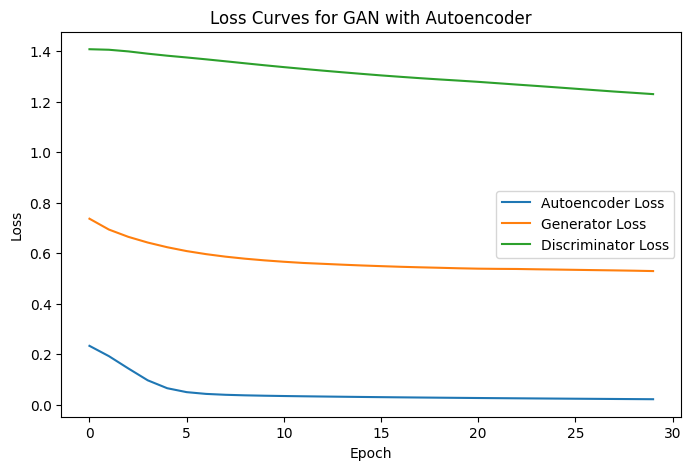

In [49]:
#best paremetes:
batch_size = int(batch_size)
num_epochs = int(num_epochs)
noise_dim = int(noise_dim)

noise_dim = noise_dim
num_epochs = num_epochs
batch_size = batch_size

autoencoder, generator, ae_losses, gen_losses, disc_losses = train_gan_autoencoder(
    X_train_preprocessed, noise_dim, embed_dim, num_epochs, batch_size, device, seed, gen_lr, disc_lr)

# Plot Losses
plt.figure(figsize=(8, 5))
plt.plot(ae_losses, label="Autoencoder Loss")
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for GAN with Autoencoder")
plt.legend()
plt.show()

In [50]:
# After the training loop finishes
generator.eval()  # Ensure the generator is in evaluation mode
autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

# 1) Determine the number of synthetic samples (match training dataset size)
num_synthetic_samples = X_train_preprocessed.shape[0]

# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


noise = torch.randn((num_synthetic_samples, noise_dim), device=device)

# 2) Generate synthetic embeddings using the generator
with torch.no_grad():
    synthetic_embeddings = generator(noise)

# 3) Decode the embeddings to reconstruct synthetic data
with torch.no_grad():
    synthetic_data_tensor = autoencoder.decoder(synthetic_embeddings)

# 4) Convert the synthetic data to a NumPy array for post-processing
synthetic_data = synthetic_data_tensor.cpu().numpy()

# Print the shape of the synthetic dataset
print(f"Synthetic dataset generated with shape: {synthetic_data.shape}")

synthetic_data_copy = synthetic_data.copy()


Synthetic dataset generated with shape: (26048, 108)


In [51]:
# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# Rescale continuous features back to original range
synthetic_continuous_df = pd.DataFrame(
    synthetic_data[:, :len(continuous_features)],
    columns=continuous_features  # Use the correct feature names
)
synthetic_continuous = scaler.inverse_transform(synthetic_continuous_df)

# Decode categorical features back to original categories
synthetic_categorical = oh_encoder.inverse_transform(
    synthetic_data[:, len(continuous_features):]
)

# Combine continuous and categorical features into a single dataset
synthetic_combined = np.hstack([synthetic_continuous, synthetic_categorical])

# Create a DataFrame for the synthetic dataset
synthetic_df = pd.DataFrame(
    synthetic_combined,
    columns=continuous_features + categorical_features
)

# Print the shape and preview the synthetic dataset
print("Synthetic Dataset Shape (Post-Processed):", synthetic_df.shape)
print(synthetic_df.head())

synthetic_df_copy = synthetic_df.copy()

Synthetic Dataset Shape (Post-Processed): (26048, 14)
         age       fnlwgt education-num  capital-gain capital-loss  \
0  49.491558  523124.9375      9.045515  30629.251953  1394.346191   
1  49.618713  527324.3125      9.889047  31211.638672  1442.927246   
2  48.818027   568972.125      9.320401    34416.0625  1595.173096   
3  48.951881     550975.5      9.159557  33933.441406  1495.981689   
4  46.686745  632055.0625       9.29316   33913.46875  1626.954712   

  hours-per-week         workclass     education      marital-status  \
0      47.031502  Self-emp-not-inc     Bachelors       Never-married   
1      47.758194  Self-emp-not-inc     Bachelors  Married-civ-spouse   
2      45.694931           Private  Some-college  Married-civ-spouse   
3      47.667263           Private  Some-college  Married-civ-spouse   
4      48.116596           Private  Some-college       Never-married   

       occupation   relationship   race     sex native-country  
0  Prof-specialty      Own-

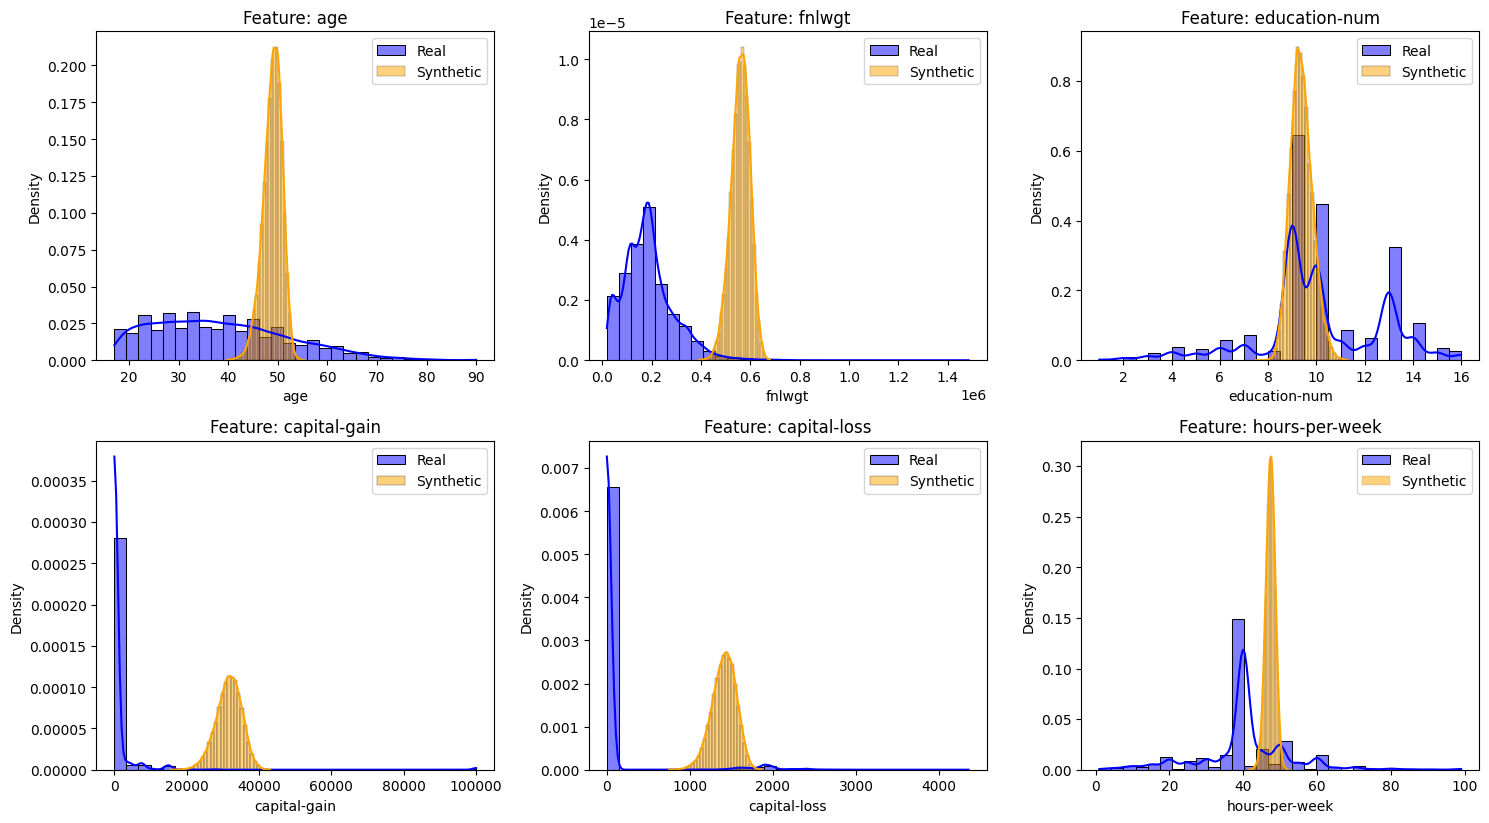

In [52]:
# Number of features
num_features = len(continuous_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each feature
for idx, feature in enumerate(continuous_features):
    ax = axes[idx]

    # Real data column
    real_data_col = X_train_1[feature]  # Adjust if the real data structure differs
    sns.histplot(real_data_col, color='blue', kde=True, label='Real', stat='density', bins=30, ax=ax)

    # Synthetic data column from synthetic_df_copy
    synthetic_data_col = synthetic_df_copy[feature]
    sns.histplot(synthetic_data_col, color='orange', kde=True, label='Synthetic', stat='density', bins=30, ax=ax)

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


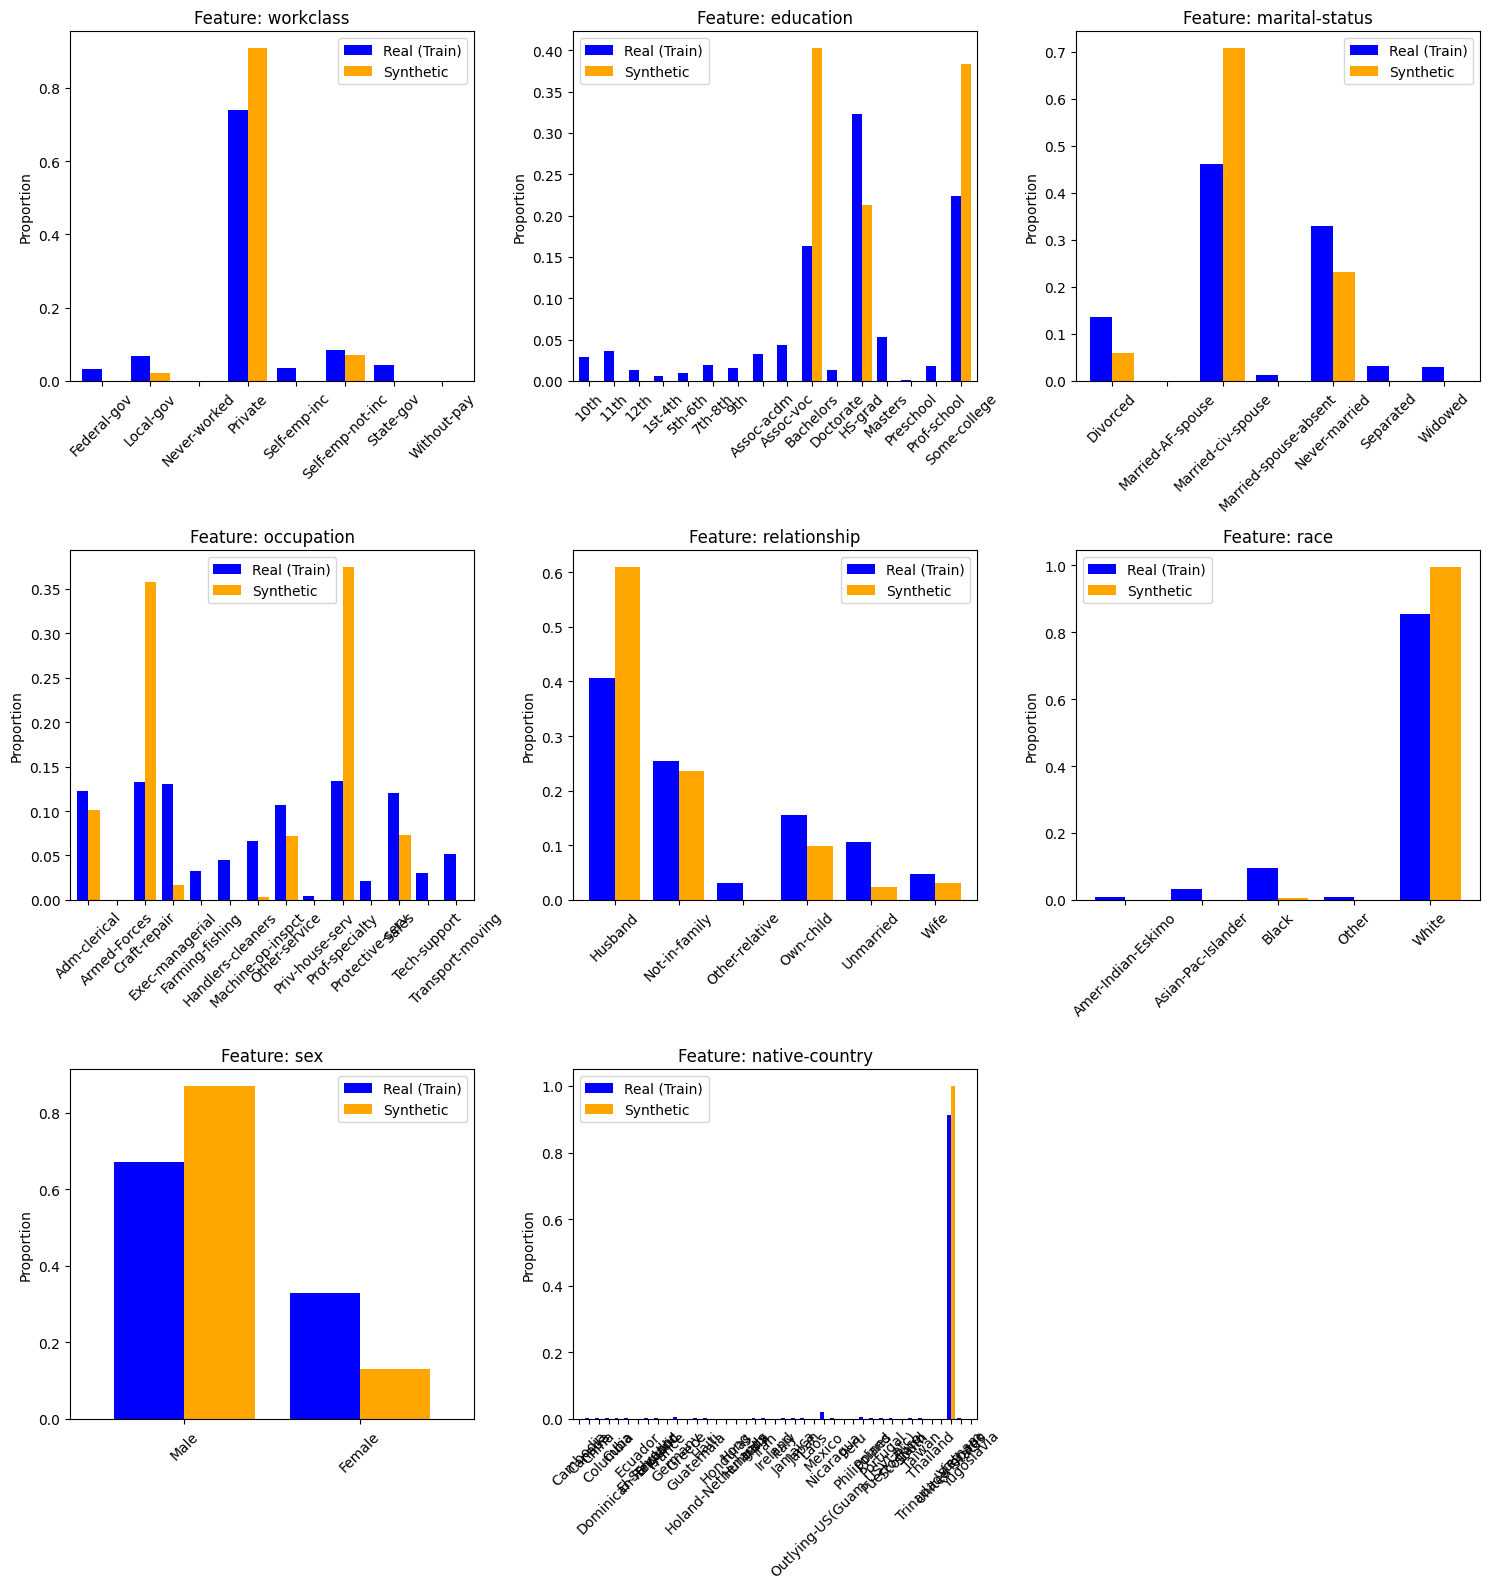

In [53]:
# Number of features
num_features = len(categorical_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each categorical feature
for idx, feature in enumerate(categorical_features):
    ax = axes[idx]

    # Real distribution
    real_counts = X_train_1[feature].value_counts(normalize=True)

    # Synthetic distribution
    synth_counts = synthetic_df_copy[feature].value_counts(normalize=True)

    # Combine and plot
    comparison_df = pd.DataFrame({'Real (Train)': real_counts, 'Synthetic': synth_counts}).fillna(0)
    comparison_df.plot(kind='bar', width=0.8, ax=ax, color=['blue', 'orange'])

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


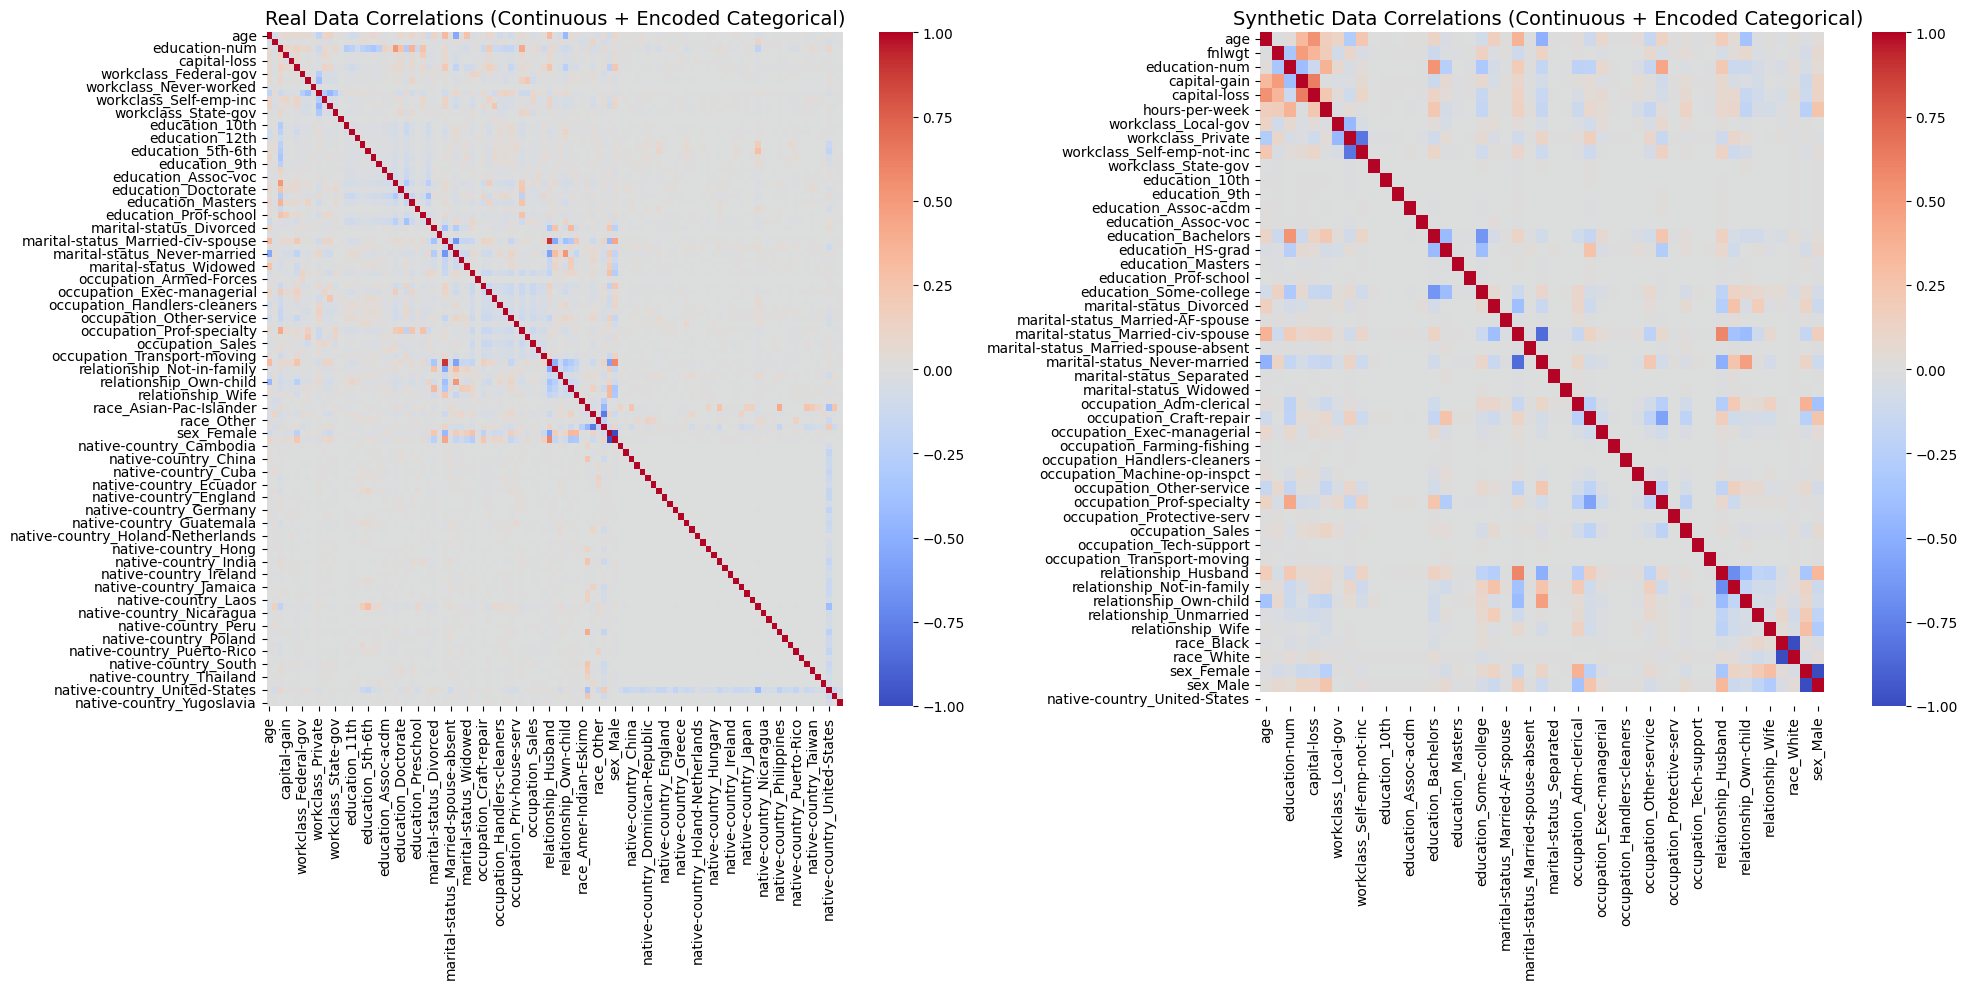

In [54]:
from scipy.stats import pearsonr
import numpy as np

# Combine continuous and one-hot-encoded categorical features
combined_features = pd.concat(
    [X_train_1[continuous_features], pd.get_dummies(X_train_1[categorical_features], drop_first=False)],
    axis=1
)

# Calculate correlations for real data
real_corr = combined_features.corr()

# For synthetic data
synthetic_combined_features = pd.concat(
    [synthetic_df_copy[continuous_features], pd.get_dummies(synthetic_df_copy[categorical_features], drop_first=False)],
    axis=1
)
synthetic_corr = synthetic_combined_features.corr()

# Plot Side-by-Side Correlation Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Real Data Correlations
sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", cbar=True, annot=False)
axes[0].set_title("Real Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

# Synthetic Data Correlations
sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", cbar=True, annot=False)
axes[1].set_title("Synthetic Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

plt.tight_layout()
plt.show()


second seed = 2

In [55]:
seed = 2

In [56]:
# Define which columns are continuous vs. categorical
continuous_features = ['age', 'fnlwgt', 'education-num',
                       'capital-gain', 'capital-loss', 'hours-per-week']

categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'sex',
                        'native-country']

# --- 1. Scale continuous features using MinMaxScaler ---
# Fit the scaler on the original (unnormalized) continuous data
scaler = MinMaxScaler()

scaler.fit(X_train_2[continuous_features])  # Fit on the original data
X_train_cont_scaled = scaler.transform(X_train_2[continuous_features])
X_test_cont_scaled = scaler.transform(X_test_2[continuous_features])

# --- 2. Encode categorical features using OneHotEncoder ---
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat_encoded = oh_encoder.fit_transform(X_train_2[categorical_features])
X_test_cat_encoded = oh_encoder.transform(X_test_2[categorical_features])

# --- 3. Combine scaled continuous features and one-hot categorical features ---
X_train_preprocessed = np.hstack([X_train_cont_scaled, X_train_cat_encoded])
X_test_preprocessed = np.hstack([X_test_cont_scaled, X_test_cat_encoded])

# Print the shapes to verify
print("Shapes after preprocessing:")
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("X_test_preprocessed  shape:", X_test_preprocessed.shape)


Shapes after preprocessing:
X_train_preprocessed shape: (26048, 108)
X_test_preprocessed  shape: (6513, 108)


In [57]:
# Fixed parameters
gen_lr = 0.0001  # Generator learning rate
disc_lr = 0.00001  # Discriminator learning rate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 32  # Size of the latent embedding space

# Parameters for the experiments
batch_sizes = [128, 256, 512]
num_epochs_list = [30, 50]
noise_dims = [100, 200]

# Placeholder for results
results = []

# Perform experiments
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for noise_dim in noise_dims:
            # Train the models
            autoencoder, generator, ae_losses, gen_losses, disc_losses = train_gan_autoencoder(
                X_train_preprocessed, noise_dim, embed_dim=embed_dim, num_epochs=num_epochs, batch_size=batch_size,
                device=device, seed=seed, gen_lr=gen_lr, disc_lr=disc_lr
            )

            # Generate synthetic data
            num_synthetic_samples = X_train_preprocessed.shape[0]
            # Fix the random seed for reproducibility
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            noise = torch.randn((num_synthetic_samples, noise_dim), device=device)
            with torch.no_grad():
                synthetic_embeddings = generator(noise)
                synthetic_data_tensor = autoencoder.decoder(synthetic_embeddings)
            synthetic_data = synthetic_data_tensor.cpu().numpy()

            # Calculate metrics
            auc_real, auc_synth, efficacy_ratio = efficacy_metric(
                X_train_preprocessed, y_train_2, X_test_preprocessed, y_test_2, synthetic_data, seed
            )

            real_data_80 = X_train_preprocessed[:int(0.8 * X_train_preprocessed.shape[0])]
            synthetic_data_80 = synthetic_data[:real_data_80.shape[0]]
            detection_auc = detection_metric(real_data_80, synthetic_data_80, seed)

            # Append results to the list
            results.append({
                "Batch Size": batch_size,
                "Num Epochs": num_epochs,
                "Noise Dim": noise_dim,
                "Real->Real AUC": auc_real,
                "Synthetic->Real AUC": auc_synth,
                "Efficacy Ratio": efficacy_ratio,
                "Detection AUC": detection_auc
            })

# Create DataFrame from results
results_df_second_seed = pd.DataFrame(results)

# Display the results
def display_results(df):
    print(df.head())  # Replace with an actual visualization or export logic if needed

# Display or return the results DataFrame
display_results(results_df_second_seed)


Epoch: 1 Step: 0 Gen Loss: 0.7219 Disc Fake Loss: 0.6725 Disc Real Loss: 0.7290 Disc Total Loss: 1.4015 AE Loss: 0.2504
Epoch: 1 Step: 50 Gen Loss: 0.6453 Disc Fake Loss: 0.6969 Disc Real Loss: 0.7177 Disc Total Loss: 1.4146 AE Loss: 0.2140
Epoch: 1 Step: 100 Gen Loss: 0.6013 Disc Fake Loss: 0.7139 Disc Real Loss: 0.7040 Disc Total Loss: 1.4178 AE Loss: 0.1757
Epoch: 1 Step: 150 Gen Loss: 0.5754 Disc Fake Loss: 0.7173 Disc Real Loss: 0.6993 Disc Total Loss: 1.4165 AE Loss: 0.1336
Epoch: 1 Step: 200 Gen Loss: 0.5579 Disc Fake Loss: 0.7153 Disc Real Loss: 0.6933 Disc Total Loss: 1.4086 AE Loss: 0.0889
Epoch: 1 Step: 0 Gen Loss: 0.6130 Disc Total Loss: 1.4147 AE Loss: 0.1719
Epoch: 2 Step: 0 Gen Loss: 0.5568 Disc Fake Loss: 0.7151 Disc Real Loss: 0.6898 Disc Total Loss: 1.4049 AE Loss: 0.0861
Epoch: 2 Step: 50 Gen Loss: 0.5442 Disc Fake Loss: 0.7131 Disc Real Loss: 0.6842 Disc Total Loss: 1.3973 AE Loss: 0.0614


Epoch: 2 Step: 100 Gen Loss: 0.5338 Disc Fake Loss: 0.7120 Disc Real Loss: 0.6742 Disc Total Loss: 1.3862 AE Loss: 0.0477
Epoch: 2 Step: 150 Gen Loss: 0.5257 Disc Fake Loss: 0.7112 Disc Real Loss: 0.6730 Disc Total Loss: 1.3842 AE Loss: 0.0437
Epoch: 2 Step: 200 Gen Loss: 0.5186 Disc Fake Loss: 0.7100 Disc Real Loss: 0.6666 Disc Total Loss: 1.3765 AE Loss: 0.0383
Epoch: 2 Step: 0 Gen Loss: 0.5349 Disc Total Loss: 1.3892 AE Loss: 0.0531
Epoch: 3 Step: 0 Gen Loss: 0.5181 Disc Fake Loss: 0.7099 Disc Real Loss: 0.6639 Disc Total Loss: 1.3738 AE Loss: 0.0377
Epoch: 3 Step: 50 Gen Loss: 0.5138 Disc Fake Loss: 0.7071 Disc Real Loss: 0.6603 Disc Total Loss: 1.3674 AE Loss: 0.0380
Epoch: 3 Step: 100 Gen Loss: 0.5087 Disc Fake Loss: 0.7047 Disc Real Loss: 0.6514 Disc Total Loss: 1.3561 AE Loss: 0.0346
Epoch: 3 Step: 150 Gen Loss: 0.5039 Disc Fake Loss: 0.7019 Disc Real Loss: 0.6532 Disc Total Loss: 1.3551 AE Loss: 0.0361
Epoch: 3 Step: 200 Gen Loss: 0.4996 Disc Fake Loss: 0.6994 Disc Real Loss: 

In [58]:
# Order the results DataFrame by "Efficacy Ratio" in descending order
results_df_second_seed = results_df_second_seed.sort_values(by="Efficacy Ratio", ascending=False)

# Save DataFrame to CSV
csv_file_path = "experiment_results_second_seed_gan.csv"
results_df_second_seed.to_csv(csv_file_path, index=False)

print(f"Results saved to {csv_file_path}")

print(results_df_second_seed.head(1))

Results saved to experiment_results_second_seed_gan.csv
   Batch Size  Num Epochs  Noise Dim  Real->Real AUC  Synthetic->Real AUC  \
2         128          50        100        0.905971             0.715151   

   Efficacy Ratio  Detection AUC  
2        0.789375            1.0  


In [59]:
# Extract the top row
top_result = results_df_second_seed.iloc[0]

# Extract individual values
batch_size = top_result["Batch Size"]
num_epochs = top_result["Num Epochs"]
noise_dim = top_result["Noise Dim"]
auc_real = top_result["Real->Real AUC"]
auc_synth = top_result["Synthetic->Real AUC"]
efficacy_ratio = top_result["Efficacy Ratio"]
detection_auc = top_result["Detection AUC"]

# Print results in your desired format
print(f"Detection Metric (Average AUC): {detection_auc:.4f}")
print(f"Real->Real AUC: {auc_real:.4f}")
print(f"Synthetic->Real AUC: {auc_synth:.4f}")
print(f"Efficacy Ratio: {efficacy_ratio:.4f}")
print(" ")
print(f"Batch Size: {batch_size}, Num Epochs: {num_epochs}, Noise Dim: {noise_dim} ")


efficacy_ratio_second_seed = efficacy_ratio
detection_auc_second_seed = detection_auc



Detection Metric (Average AUC): 1.0000
Real->Real AUC: 0.9060
Synthetic->Real AUC: 0.7152
Efficacy Ratio: 0.7894
 
Batch Size: 128.0, Num Epochs: 50.0, Noise Dim: 100.0 


Epoch: 1 Step: 0 Gen Loss: 0.7219 Disc Fake Loss: 0.6725 Disc Real Loss: 0.7290 Disc Total Loss: 1.4015 AE Loss: 0.2504
Epoch: 1 Step: 50 Gen Loss: 0.6453 Disc Fake Loss: 0.6969 Disc Real Loss: 0.7177 Disc Total Loss: 1.4146 AE Loss: 0.2140
Epoch: 1 Step: 100 Gen Loss: 0.6013 Disc Fake Loss: 0.7139 Disc Real Loss: 0.7040 Disc Total Loss: 1.4178 AE Loss: 0.1757
Epoch: 1 Step: 150 Gen Loss: 0.5754 Disc Fake Loss: 0.7173 Disc Real Loss: 0.6993 Disc Total Loss: 1.4165 AE Loss: 0.1336
Epoch: 1 Step: 200 Gen Loss: 0.5579 Disc Fake Loss: 0.7153 Disc Real Loss: 0.6933 Disc Total Loss: 1.4086 AE Loss: 0.0889
Epoch: 1 Step: 0 Gen Loss: 0.6130 Disc Total Loss: 1.4147 AE Loss: 0.1719
Epoch: 2 Step: 0 Gen Loss: 0.5568 Disc Fake Loss: 0.7151 Disc Real Loss: 0.6898 Disc Total Loss: 1.4049 AE Loss: 0.0861
Epoch: 2 Step: 50 Gen Loss: 0.5442 Disc Fake Loss: 0.7131 Disc Real Loss: 0.6842 Disc Total Loss: 1.3973 AE Loss: 0.0614
Epoch: 2 Step: 100 Gen Loss: 0.5338 Disc Fake Loss: 0.7120 Disc Real Loss: 0.6

Epoch: 6 Step: 50 Gen Loss: 0.4684 Disc Fake Loss: 0.6619 Disc Real Loss: 0.6204 Disc Total Loss: 1.2823 AE Loss: 0.0285
Epoch: 6 Step: 100 Gen Loss: 0.4646 Disc Fake Loss: 0.6569 Disc Real Loss: 0.6142 Disc Total Loss: 1.2711 AE Loss: 0.0256
Epoch: 6 Step: 150 Gen Loss: 0.4600 Disc Fake Loss: 0.6525 Disc Real Loss: 0.6205 Disc Total Loss: 1.2731 AE Loss: 0.0274
Epoch: 6 Step: 200 Gen Loss: 0.4555 Disc Fake Loss: 0.6485 Disc Real Loss: 0.6154 Disc Total Loss: 1.2639 AE Loss: 0.0250
Epoch: 6 Step: 0 Gen Loss: 0.4641 Disc Total Loss: 1.2740 AE Loss: 0.0267
Epoch: 7 Step: 0 Gen Loss: 0.4557 Disc Fake Loss: 0.6481 Disc Real Loss: 0.6096 Disc Total Loss: 1.2577 AE Loss: 0.0252
Epoch: 7 Step: 50 Gen Loss: 0.4512 Disc Fake Loss: 0.6435 Disc Real Loss: 0.6147 Disc Total Loss: 1.2582 AE Loss: 0.0263
Epoch: 7 Step: 100 Gen Loss: 0.4469 Disc Fake Loss: 0.6380 Disc Real Loss: 0.6099 Disc Total Loss: 1.2479 AE Loss: 0.0236
Epoch: 7 Step: 150 Gen Loss: 0.4434 Disc Fake Loss: 0.6330 Disc Real Loss: 0

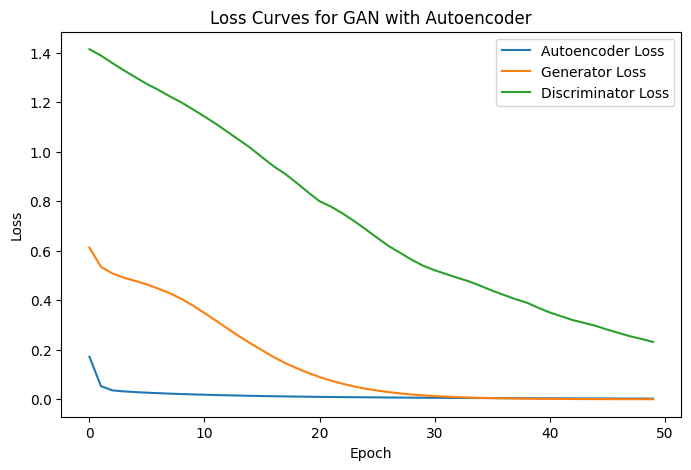

In [60]:
batch_size = int(batch_size)
num_epochs = int(num_epochs)
noise_dim = int(noise_dim)

noise_dim = noise_dim
num_epochs = num_epochs
batch_size = batch_size

autoencoder, generator, ae_losses, gen_losses, disc_losses = train_gan_autoencoder(
    X_train_preprocessed, noise_dim, embed_dim, num_epochs, batch_size, device, seed, gen_lr, disc_lr)

# Plot Losses
plt.figure(figsize=(8, 5))
plt.plot(ae_losses, label="Autoencoder Loss")
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for GAN with Autoencoder")
plt.legend()
plt.show()

In [61]:
# After the training loop finishes
generator.eval()  # Ensure the generator is in evaluation mode
autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

# 1) Determine the number of synthetic samples (match training dataset size)
num_synthetic_samples = X_train_preprocessed.shape[0]

# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


noise = torch.randn((num_synthetic_samples, noise_dim), device=device)

# 2) Generate synthetic embeddings using the generator
with torch.no_grad():
    synthetic_embeddings = generator(noise)

# 3) Decode the embeddings to reconstruct synthetic data
with torch.no_grad():
    synthetic_data_tensor = autoencoder.decoder(synthetic_embeddings)

# 4) Convert the synthetic data to a NumPy array for post-processing
synthetic_data = synthetic_data_tensor.cpu().numpy()

# Print the shape of the synthetic dataset
print(f"Synthetic dataset generated with shape: {synthetic_data.shape}")

synthetic_data_copy = synthetic_data.copy()


Synthetic dataset generated with shape: (26048, 108)


In [62]:
# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# Rescale continuous features back to original range
synthetic_continuous_df = pd.DataFrame(
    synthetic_data[:, :len(continuous_features)],
    columns=continuous_features  # Use the correct feature names
)
synthetic_continuous = scaler.inverse_transform(synthetic_continuous_df)

# Decode categorical features back to original categories
synthetic_categorical = oh_encoder.inverse_transform(
    synthetic_data[:, len(continuous_features):]
)

# Combine continuous and categorical features into a single dataset
synthetic_combined = np.hstack([synthetic_continuous, synthetic_categorical])

# Create a DataFrame for the synthetic dataset
synthetic_df = pd.DataFrame(
    synthetic_combined,
    columns=continuous_features + categorical_features
)

# Print the shape and preview the synthetic dataset
print("Synthetic Dataset Shape (Post-Processed):", synthetic_df.shape)
print(synthetic_df.head())

synthetic_df_copy = synthetic_df.copy()

Synthetic Dataset Shape (Post-Processed): (26048, 14)
         age        fnlwgt education-num capital-gain capital-loss  \
0  44.117283  491754.34375      9.336596  8938.314453   738.905762   
1   46.65007      460132.0     10.150394  6115.595703   386.247467   
2  43.644375    467863.625     10.104729  6666.507324    609.10022   
3  40.233574  395365.09375      8.865655  4174.550781   301.391113   
4  49.518864  390896.40625      9.078356  3374.505859   477.251862   

  hours-per-week  workclass     education      marital-status      occupation  \
0      44.763145  Local-gov    Assoc-acdm  Married-civ-spouse  Prof-specialty   
1      42.969227       None     Bachelors       Never-married   Other-service   
2      46.668835    Private       HS-grad            Divorced    Craft-repair   
3      44.779984    Private  Some-college  Married-civ-spouse           Sales   
4      46.015118    Private  Some-college  Married-civ-spouse    Adm-clerical   

    relationship   race     sex native

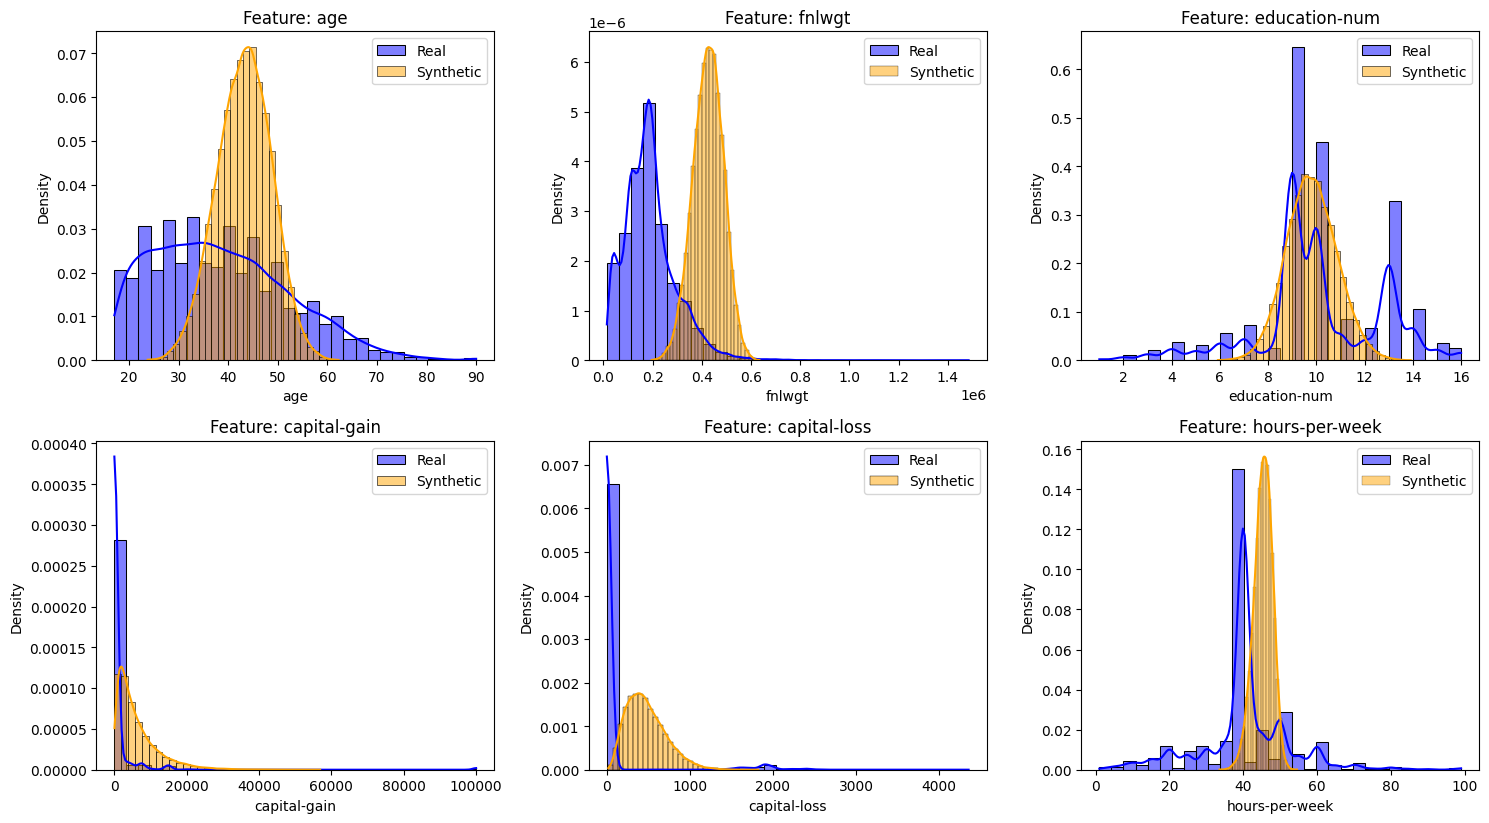

In [63]:
# Number of features
num_features = len(continuous_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each feature
for idx, feature in enumerate(continuous_features):
    ax = axes[idx]

    # Real data column
    real_data_col = X_train_2[feature]  # Adjust if the real data structure differs
    sns.histplot(real_data_col, color='blue', kde=True, label='Real', stat='density', bins=30, ax=ax)

    # Synthetic data column from synthetic_df_copy
    synthetic_data_col = synthetic_df_copy[feature]
    sns.histplot(synthetic_data_col, color='orange', kde=True, label='Synthetic', stat='density', bins=30, ax=ax)

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


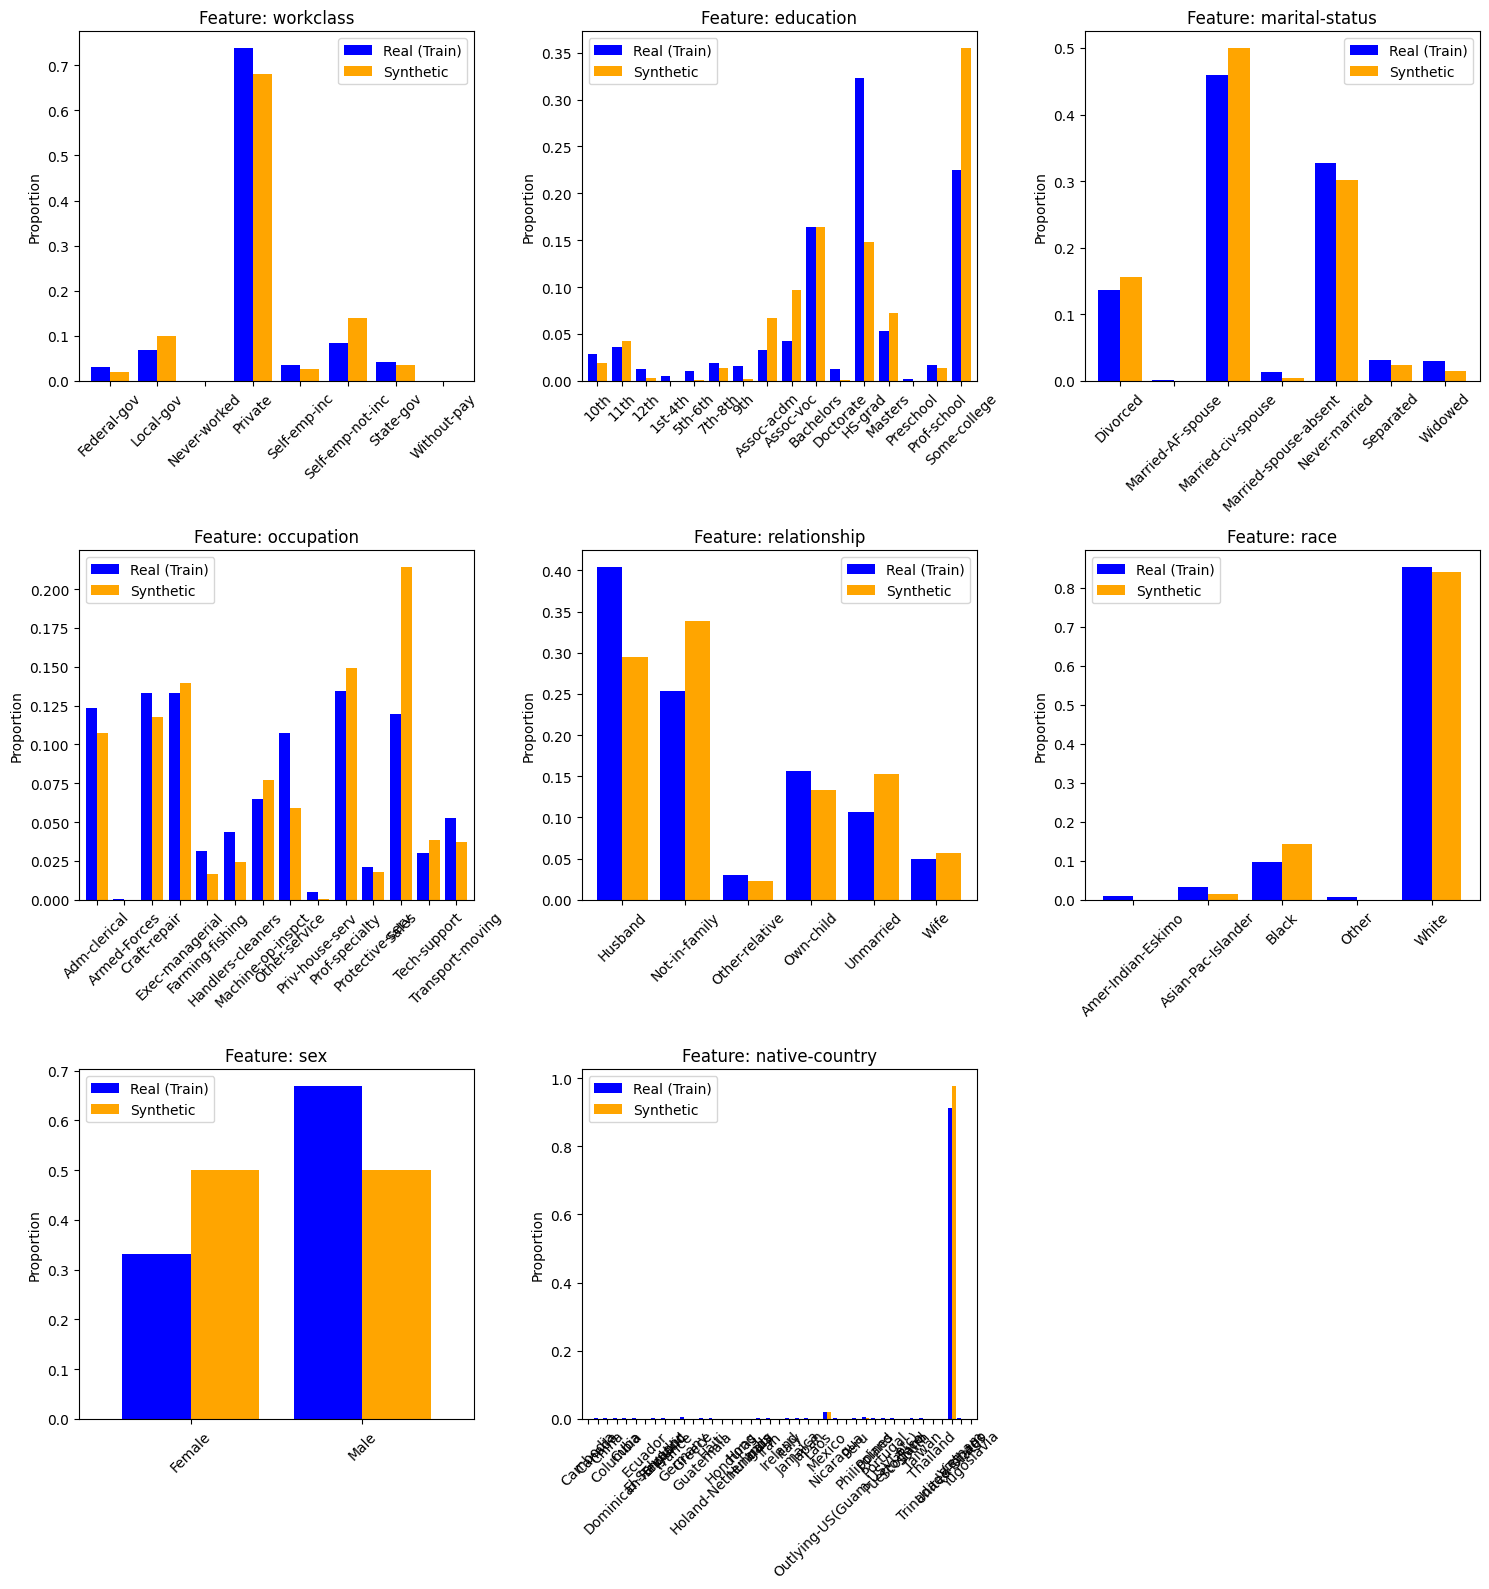

In [64]:
# Number of features
num_features = len(categorical_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each categorical feature
for idx, feature in enumerate(categorical_features):
    ax = axes[idx]

    # Real distribution
    real_counts = X_train_2[feature].value_counts(normalize=True)

    # Synthetic distribution
    synth_counts = synthetic_df_copy[feature].value_counts(normalize=True)

    # Combine and plot
    comparison_df = pd.DataFrame({'Real (Train)': real_counts, 'Synthetic': synth_counts}).fillna(0)
    comparison_df.plot(kind='bar', width=0.8, ax=ax, color=['blue', 'orange'])

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


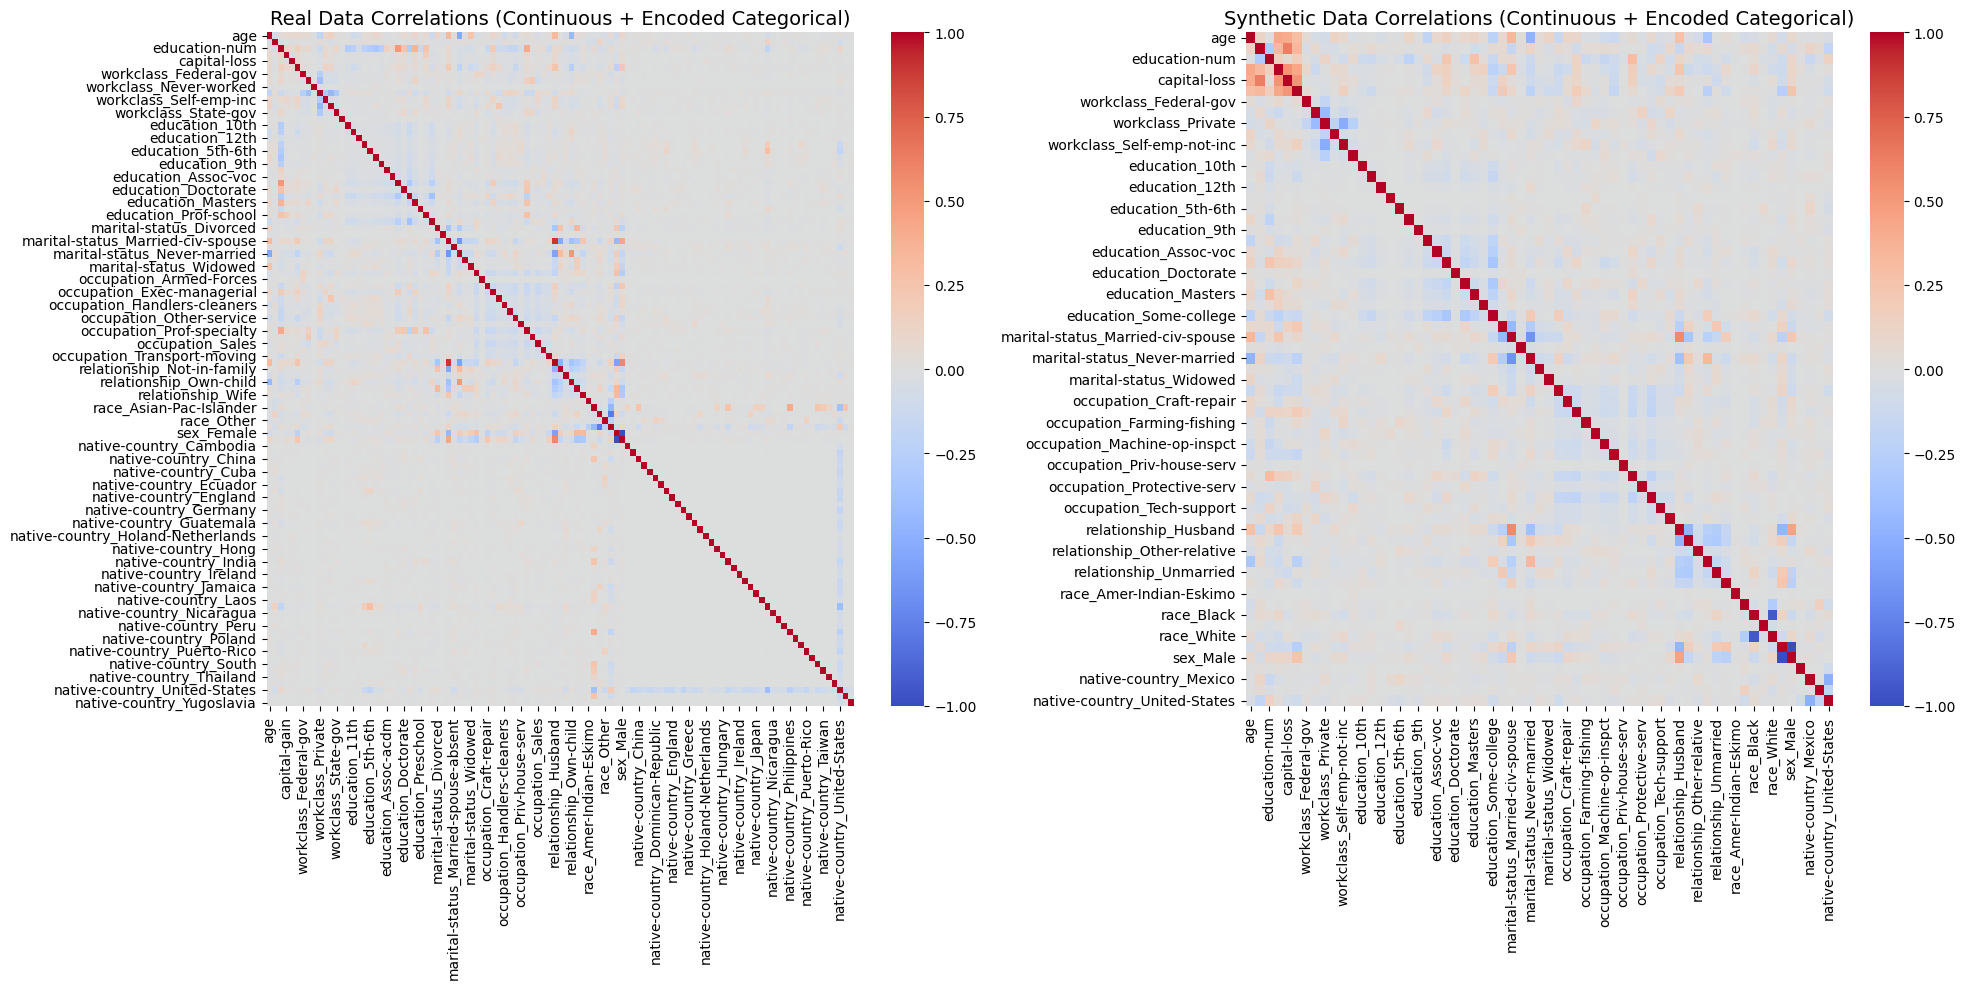

In [65]:
# Combine continuous and one-hot-encoded categorical features
combined_features = pd.concat(
    [X_train_2[continuous_features], pd.get_dummies(X_train_1[categorical_features], drop_first=False)],
    axis=1
)

# Calculate correlations for real data
real_corr = combined_features.corr()

# For synthetic data
synthetic_combined_features = pd.concat(
    [synthetic_df_copy[continuous_features], pd.get_dummies(synthetic_df_copy[categorical_features], drop_first=False)],
    axis=1
)
synthetic_corr = synthetic_combined_features.corr()

# Plot Side-by-Side Correlation Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Real Data Correlations
sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", cbar=True, annot=False)
axes[0].set_title("Real Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

# Synthetic Data Correlations
sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", cbar=True, annot=False)
axes[1].set_title("Synthetic Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

plt.tight_layout()
plt.show()


third seed = 3

In [66]:
seed = 3

In [67]:
# --- 1. Scale continuous features using MinMaxScaler ---
# Fit the scaler on the original (unnormalized) continuous data
scaler = MinMaxScaler()

scaler.fit(X_train_3[continuous_features])  # Fit on the original data
X_train_cont_scaled = scaler.transform(X_train_3[continuous_features])
X_test_cont_scaled = scaler.transform(X_test_3[continuous_features])

# --- 2. Encode categorical features using OneHotEncoder ---
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat_encoded = oh_encoder.fit_transform(X_train_3[categorical_features])
X_test_cat_encoded = oh_encoder.transform(X_test_3[categorical_features])

# --- 3. Combine scaled continuous features and one-hot categorical features ---
X_train_preprocessed = np.hstack([X_train_cont_scaled, X_train_cat_encoded])
X_test_preprocessed = np.hstack([X_test_cont_scaled, X_test_cat_encoded])

# Print the shapes to verify
print("Shapes after preprocessing:")
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("X_test_preprocessed  shape:", X_test_preprocessed.shape)


Shapes after preprocessing:
X_train_preprocessed shape: (26048, 108)
X_test_preprocessed  shape: (6513, 108)


In [68]:
# Fixed parameters
gen_lr = 0.0001  # Generator learning rate
disc_lr = 0.00001  # Discriminator learning rate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 32  # Size of the latent embedding space

# Parameters for the experiments
batch_sizes = [128, 256, 512]
num_epochs_list = [30, 50]
noise_dims = [100, 200]

# Placeholder for results
results = []

# Perform experiments
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for noise_dim in noise_dims:
            # Train the models
            autoencoder, generator, ae_losses, gen_losses, disc_losses = train_gan_autoencoder(
                X_train_preprocessed, noise_dim, embed_dim=embed_dim, num_epochs=num_epochs, batch_size=batch_size,
                device=device, seed=seed, gen_lr=gen_lr, disc_lr=disc_lr
            )

            # Generate synthetic data
            num_synthetic_samples = X_train_preprocessed.shape[0]
            # Fix the random seed for reproducibility
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            noise = torch.randn((num_synthetic_samples, noise_dim), device=device)
            with torch.no_grad():
                synthetic_embeddings = generator(noise)
                synthetic_data_tensor = autoencoder.decoder(synthetic_embeddings)
            synthetic_data = synthetic_data_tensor.cpu().numpy()

            # Calculate metrics
            auc_real, auc_synth, efficacy_ratio = efficacy_metric(
                X_train_preprocessed, y_train_3, X_test_preprocessed, y_test_3, synthetic_data, seed
            )

            real_data_80 = X_train_preprocessed[:int(0.8 * X_train_preprocessed.shape[0])]
            synthetic_data_80 = synthetic_data[:real_data_80.shape[0]]
            detection_auc = detection_metric(real_data_80, synthetic_data_80, seed)

            # Append results to the list
            results.append({
                "Batch Size": batch_size,
                "Num Epochs": num_epochs,
                "Noise Dim": noise_dim,
                "Real->Real AUC": auc_real,
                "Synthetic->Real AUC": auc_synth,
                "Efficacy Ratio": efficacy_ratio,
                "Detection AUC": detection_auc
            })

# Create DataFrame from results
results_df_third_seed = pd.DataFrame(results)

# Display the results
def display_results(df):
    print(df.head())  # Replace with an actual visualization or export logic if needed

# Display or return the results DataFrame
display_results(results_df_third_seed)


Epoch: 1 Step: 0 Gen Loss: 0.7268 Disc Fake Loss: 0.6511 Disc Real Loss: 0.7338 Disc Total Loss: 1.3848 AE Loss: 0.2475
Epoch: 1 Step: 50 Gen Loss: 0.6560 Disc Fake Loss: 0.6801 Disc Real Loss: 0.7171 Disc Total Loss: 1.3971 AE Loss: 0.2100
Epoch: 1 Step: 100 Gen Loss: 0.6151 Disc Fake Loss: 0.6953 Disc Real Loss: 0.7177 Disc Total Loss: 1.4130 AE Loss: 0.1704
Epoch: 1 Step: 150 Gen Loss: 0.5929 Disc Fake Loss: 0.7000 Disc Real Loss: 0.7002 Disc Total Loss: 1.4002 AE Loss: 0.1258
Epoch: 1 Step: 200 Gen Loss: 0.5781 Disc Fake Loss: 0.7012 Disc Real Loss: 0.6976 Disc Total Loss: 1.3988 AE Loss: 0.0866
Epoch: 1 Step: 0 Gen Loss: 0.6269 Disc Total Loss: 1.4033 AE Loss: 0.1668
Epoch: 2 Step: 0 Gen Loss: 0.5772 Disc Fake Loss: 0.7013 Disc Real Loss: 0.6876 Disc Total Loss: 1.3889 AE Loss: 0.0860
Epoch: 2 Step: 50 Gen Loss: 0.5683 Disc Fake Loss: 0.7006 Disc Real Loss: 0.6753 Disc Total Loss: 1.3759 AE Loss: 0.0594
Epoch: 2 Step: 100 Gen Loss: 0.5579 Disc Fake Loss: 0.7006 Disc Real Loss: 0.6

Epoch: 29 Step: 150 Gen Loss: 0.0310 Disc Fake Loss: 0.3443 Disc Real Loss: 0.3529 Disc Total Loss: 0.6972 AE Loss: 0.0072
Epoch: 29 Step: 200 Gen Loss: 0.0296 Disc Fake Loss: 0.3415 Disc Real Loss: 0.3801 Disc Total Loss: 0.7215 AE Loss: 0.0068
Epoch: 29 Step: 0 Gen Loss: 0.0326 Disc Total Loss: 0.7354 AE Loss: 0.0067
Epoch: 30 Step: 0 Gen Loss: 0.0295 Disc Fake Loss: 0.3416 Disc Real Loss: 0.4013 Disc Total Loss: 0.7429 AE Loss: 0.0061
Epoch: 30 Step: 50 Gen Loss: 0.0280 Disc Fake Loss: 0.3398 Disc Real Loss: 0.3534 Disc Total Loss: 0.6932 AE Loss: 0.0063
Epoch: 30 Step: 100 Gen Loss: 0.0268 Disc Fake Loss: 0.3358 Disc Real Loss: 0.3806 Disc Total Loss: 0.7164 AE Loss: 0.0057
Epoch: 30 Step: 150 Gen Loss: 0.0255 Disc Fake Loss: 0.3325 Disc Real Loss: 0.3363 Disc Total Loss: 0.6688 AE Loss: 0.0068
Epoch: 30 Step: 200 Gen Loss: 0.0243 Disc Fake Loss: 0.3268 Disc Real Loss: 0.3657 Disc Total Loss: 0.6925 AE Loss: 0.0064
Epoch: 30 Step: 0 Gen Loss: 0.0268 Disc Total Loss: 0.7115 AE Loss:

In [69]:
# Order the results DataFrame by "Efficacy Ratio" in descending order
results_df_third_seed = results_df_third_seed.sort_values(by="Efficacy Ratio", ascending=False)

# Save DataFrame to CSV
csv_file_path = "experiment_results_third_seed_gan.csv"
results_df_third_seed.to_csv(csv_file_path, index=False)

print(f"Results saved to {csv_file_path}")

print(results_df_third_seed.head(1))

Results saved to experiment_results_third_seed_gan.csv
    Batch Size  Num Epochs  Noise Dim  Real->Real AUC  Synthetic->Real AUC  \
10         512          50        100         0.90928             0.699304   

    Efficacy Ratio  Detection AUC  
10        0.769074            1.0  


In [70]:
# Extract the top row
top_result = results_df_third_seed.iloc[0]

# Extract individual values
batch_size = top_result["Batch Size"]
num_epochs = top_result["Num Epochs"]
noise_dim = top_result["Noise Dim"]
auc_real = top_result["Real->Real AUC"]
auc_synth = top_result["Synthetic->Real AUC"]
efficacy_ratio = top_result["Efficacy Ratio"]
detection_auc = top_result["Detection AUC"]

# Print results in your desired format
print(f"Detection Metric (Average AUC): {detection_auc:.4f}")
print(f"Real->Real AUC: {auc_real:.4f}")
print(f"Synthetic->Real AUC: {auc_synth:.4f}")
print(f"Efficacy Ratio: {efficacy_ratio:.4f}")
print(" ")
print(f"Batch Size: {batch_size}, Num Epochs: {num_epochs}, Noise Dim: {noise_dim} ")


efficacy_ratio_third_seed = efficacy_ratio
detection_auc_third_seed = detection_auc


Detection Metric (Average AUC): 1.0000
Real->Real AUC: 0.9093
Synthetic->Real AUC: 0.6993
Efficacy Ratio: 0.7691
 
Batch Size: 512.0, Num Epochs: 50.0, Noise Dim: 100.0 


Epoch: 1 Step: 0 Gen Loss: 0.7314 Disc Fake Loss: 0.6581 Disc Real Loss: 0.7371 Disc Total Loss: 1.3953 AE Loss: 0.2474
Epoch: 1 Step: 50 Gen Loss: 0.6857 Disc Fake Loss: 0.6807 Disc Real Loss: 0.7236 Disc Total Loss: 1.4044 AE Loss: 0.2090
Epoch: 1 Step: 0 Gen Loss: 0.7069 Disc Total Loss: 1.4018 AE Loss: 0.2282
Epoch: 2 Step: 0 Gen Loss: 0.6844 Disc Fake Loss: 0.6820 Disc Real Loss: 0.7201 Disc Total Loss: 1.4021 AE Loss: 0.2079
Epoch: 2 Step: 50 Gen Loss: 0.6576 Disc Fake Loss: 0.6926 Disc Real Loss: 0.7090 Disc Total Loss: 1.4016 AE Loss: 0.1648
Epoch: 2 Step: 0 Gen Loss: 0.6693 Disc Total Loss: 1.4045 AE Loss: 0.1871
Epoch: 3 Step: 0 Gen Loss: 0.6568 Disc Fake Loss: 0.6937 Disc Real Loss: 0.7057 Disc Total Loss: 1.3994 AE Loss: 0.1631
Epoch: 3 Step: 50 Gen Loss: 0.6464 Disc Fake Loss: 0.6920 Disc Real Loss: 0.6967 Disc Total Loss: 1.3887 AE Loss: 0.1147
Epoch: 3 Step: 0 Gen Loss: 0.6504 Disc Total Loss: 1.3961 AE Loss: 0.1391
Epoch: 4 Step: 0 Gen Loss: 0.6460 Disc Fake Loss: 0.692

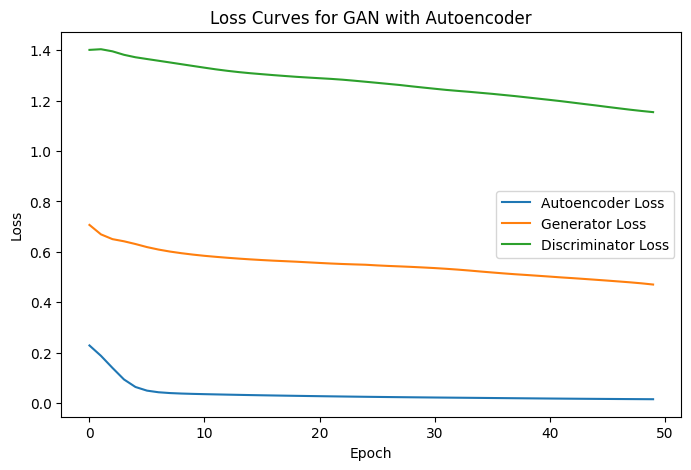

In [71]:
batch_size = int(batch_size)
num_epochs = int(num_epochs)
noise_dim = int(noise_dim)

autoencoder, generator, ae_losses, gen_losses, disc_losses = train_gan_autoencoder(
    X_train_preprocessed, noise_dim, embed_dim, num_epochs, batch_size, device, seed, gen_lr, disc_lr)

# Plot Losses
plt.figure(figsize=(8, 5))
plt.plot(ae_losses, label="Autoencoder Loss")
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for GAN with Autoencoder")
plt.legend()
plt.show()

In [72]:
# After the training loop finishes
generator.eval()  # Ensure the generator is in evaluation mode
autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

# 1) Determine the number of synthetic samples (match training dataset size)
num_synthetic_samples = X_train_preprocessed.shape[0]

# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


noise = torch.randn((num_synthetic_samples, noise_dim), device=device)

# 2) Generate synthetic embeddings using the generator
with torch.no_grad():
    synthetic_embeddings = generator(noise)

# 3) Decode the embeddings to reconstruct synthetic data
with torch.no_grad():
    synthetic_data_tensor = autoencoder.decoder(synthetic_embeddings)

# 4) Convert the synthetic data to a NumPy array for post-processing
synthetic_data = synthetic_data_tensor.cpu().numpy()

# Print the shape of the synthetic dataset
print(f"Synthetic dataset generated with shape: {synthetic_data.shape}")

synthetic_data_copy = synthetic_data.copy()


Synthetic dataset generated with shape: (26048, 108)


In [73]:
# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# Rescale continuous features back to original range
synthetic_continuous_df = pd.DataFrame(
    synthetic_data[:, :len(continuous_features)],
    columns=continuous_features  # Use the correct feature names
)
synthetic_continuous = scaler.inverse_transform(synthetic_continuous_df)

# Decode categorical features back to original categories
synthetic_categorical = oh_encoder.inverse_transform(
    synthetic_data[:, len(continuous_features):]
)

# Combine continuous and categorical features into a single dataset
synthetic_combined = np.hstack([synthetic_continuous, synthetic_categorical])

# Create a DataFrame for the synthetic dataset
synthetic_df = pd.DataFrame(
    synthetic_combined,
    columns=continuous_features + categorical_features
)

# Print the shape and preview the synthetic dataset
print("Synthetic Dataset Shape (Post-Processed):", synthetic_df.shape)
print(synthetic_df.head())

synthetic_df_copy = synthetic_df.copy()

Synthetic Dataset Shape (Post-Processed): (26048, 14)
         age        fnlwgt education-num  capital-gain capital-loss  \
0  48.985016   493307.9375      9.725261  14825.245117   666.720947   
1  44.751205     312453.25       9.24846   8338.253906   550.575317   
2  46.566086  426109.59375      8.822158   9967.201172   637.682068   
3  47.148796    444879.375      8.944771    16694.6875   689.659729   
4  40.193043   396922.4375      9.265154  13917.958008    831.30658   

  hours-per-week         workclass     education      marital-status  \
0      45.089008           Private     Bachelors  Married-civ-spouse   
1      42.866432           Private  Some-college  Married-civ-spouse   
2       42.85741  Self-emp-not-inc  Some-college  Married-civ-spouse   
3      44.041592           Private     Bachelors  Married-civ-spouse   
4      42.136677           Private  Some-college       Never-married   

       occupation   relationship   race     sex native-country  
0  Prof-specialty    

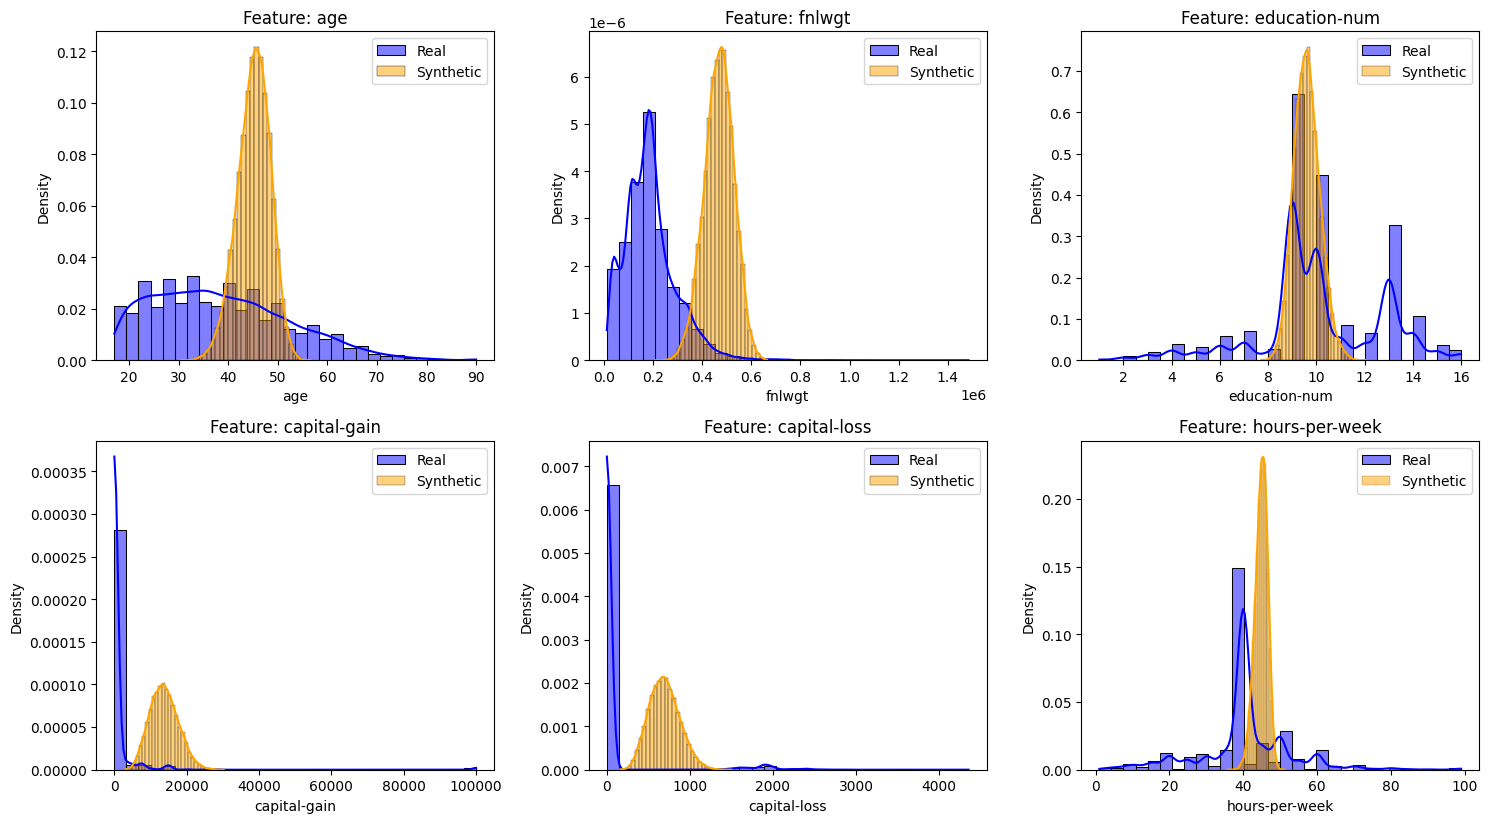

In [74]:
# Number of features
num_features = len(continuous_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each feature
for idx, feature in enumerate(continuous_features):
    ax = axes[idx]

    # Real data column
    real_data_col = X_train_3[feature]  # Adjust if the real data structure differs
    sns.histplot(real_data_col, color='blue', kde=True, label='Real', stat='density', bins=30, ax=ax)

    # Synthetic data column from synthetic_df_copy
    synthetic_data_col = synthetic_df_copy[feature]
    sns.histplot(synthetic_data_col, color='orange', kde=True, label='Synthetic', stat='density', bins=30, ax=ax)

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


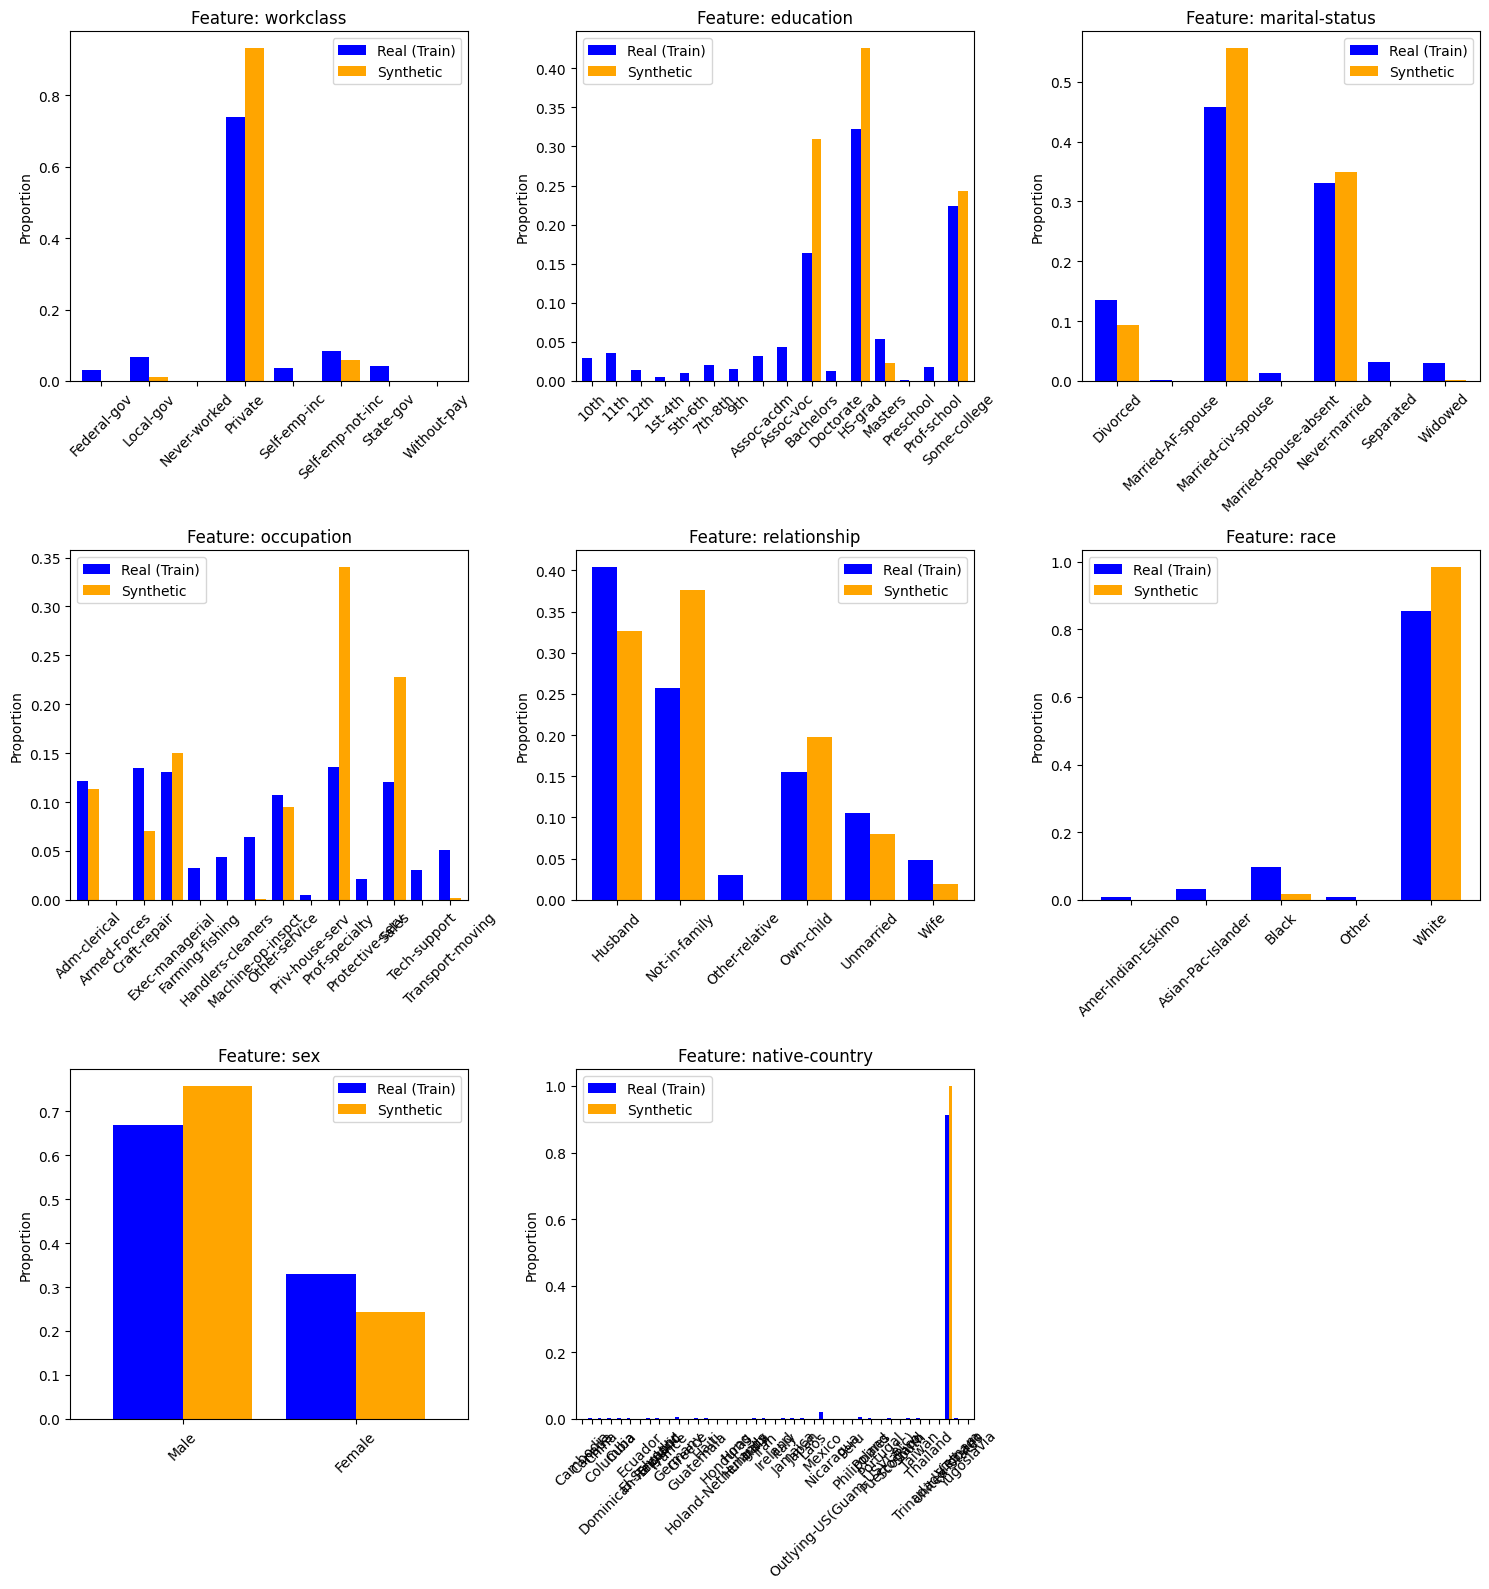

In [75]:
# Number of features
num_features = len(categorical_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each categorical feature
for idx, feature in enumerate(categorical_features):
    ax = axes[idx]

    # Real distribution
    real_counts = X_train_3[feature].value_counts(normalize=True)

    # Synthetic distribution
    synth_counts = synthetic_df_copy[feature].value_counts(normalize=True)

    # Combine and plot
    comparison_df = pd.DataFrame({'Real (Train)': real_counts, 'Synthetic': synth_counts}).fillna(0)
    comparison_df.plot(kind='bar', width=0.8, ax=ax, color=['blue', 'orange'])

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


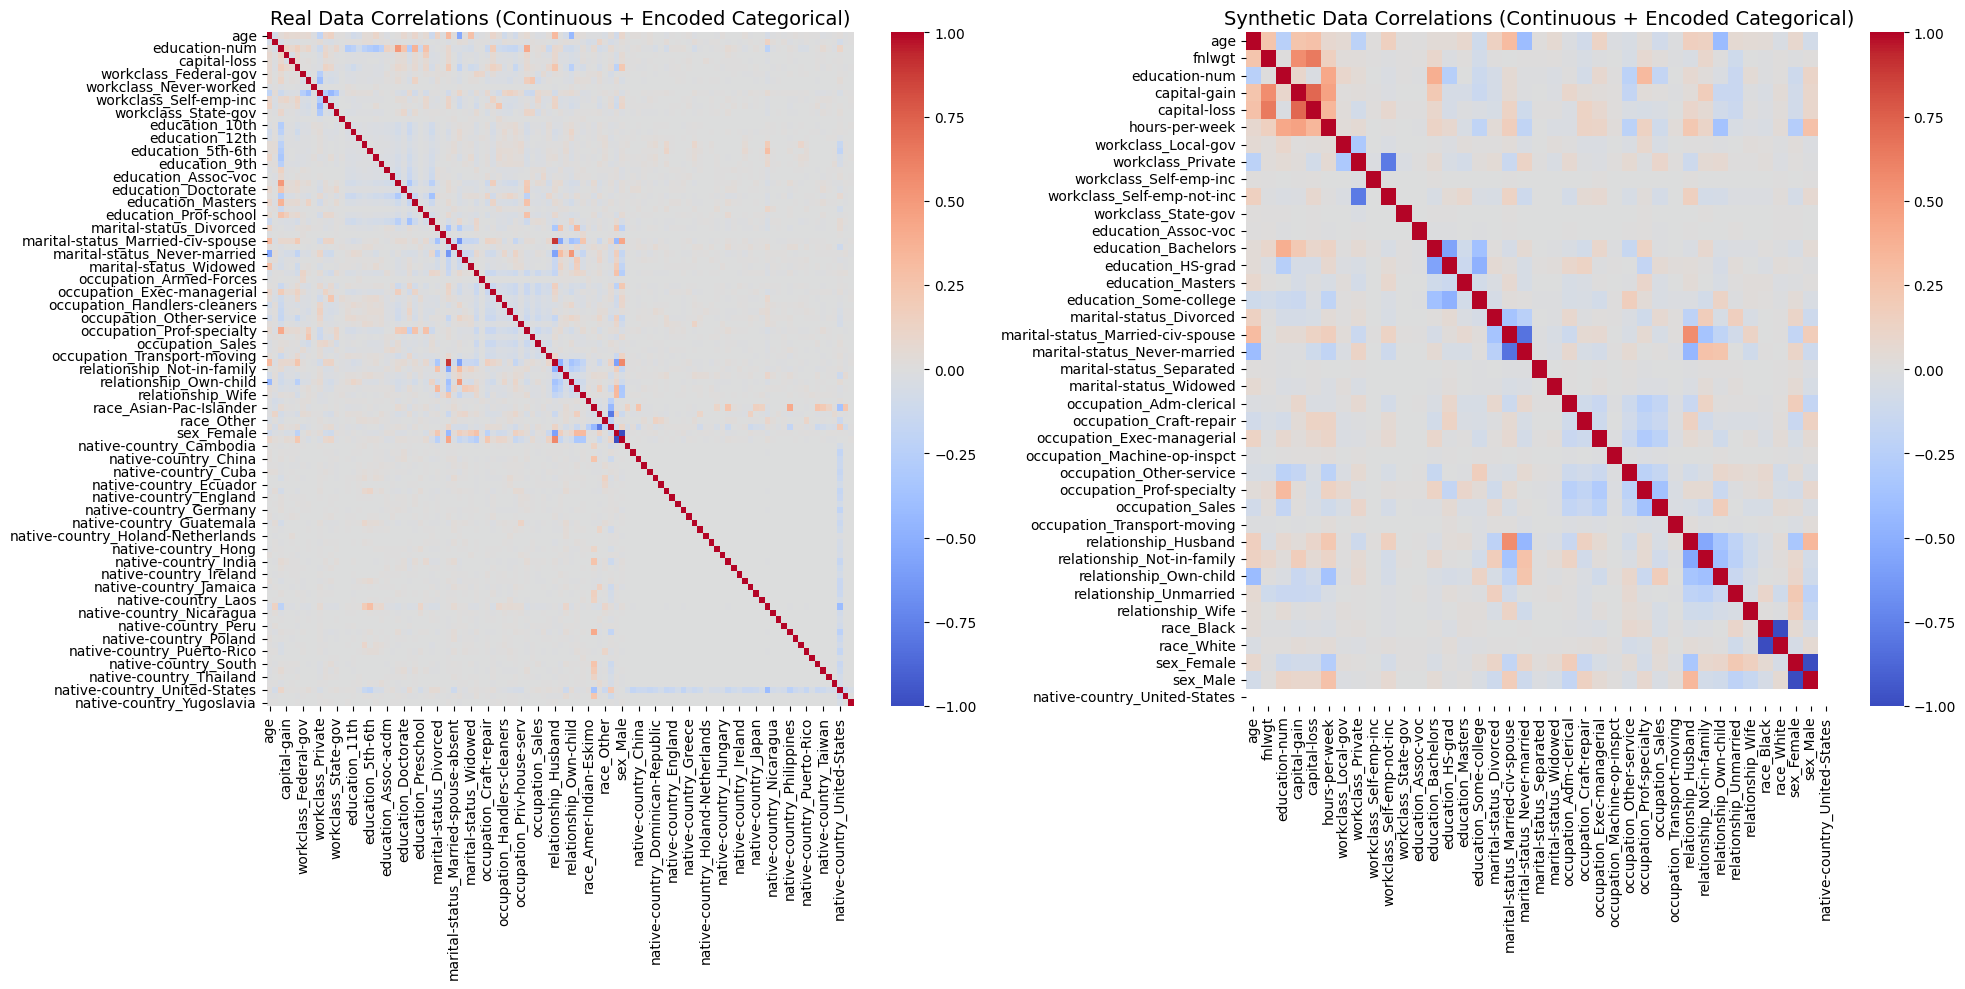

In [76]:
from scipy.stats import pearsonr
import numpy as np

# Combine continuous and one-hot-encoded categorical features
combined_features = pd.concat(
    [X_train_3[continuous_features], pd.get_dummies(X_train_3[categorical_features], drop_first=False)],
    axis=1
)

# Calculate correlations for real data
real_corr = combined_features.corr()

# For synthetic data
synthetic_combined_features = pd.concat(
    [synthetic_df_copy[continuous_features], pd.get_dummies(synthetic_df_copy[categorical_features], drop_first=False)],
    axis=1
)
synthetic_corr = synthetic_combined_features.corr()

# Plot Side-by-Side Correlation Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Real Data Correlations
sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", cbar=True, annot=False)
axes[0].set_title("Real Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

# Synthetic Data Correlations
sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", cbar=True, annot=False)
axes[1].set_title("Synthetic Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

plt.tight_layout()
plt.show()


ממוצע עבור 3 הסידים:

In [77]:
# Print the results
print("efficacy:")
print(f"seed1: {efficacy_ratio_first_seed:.4f}")
print(f"seed2: {efficacy_ratio_second_seed:.4f}")
print(f"seed3: {efficacy_ratio_third_seed:.4f}")

efficacy:
seed1: 0.7603
seed2: 0.7894
seed3: 0.7691


In [78]:
# Store results for each seed in lists
efficacy_ratios = [efficacy_ratio_first_seed, efficacy_ratio_second_seed, efficacy_ratio_third_seed]
detection_aucs = [detection_auc_first_seed, detection_auc_second_seed, detection_auc_third_seed]

# Calculate the averages
avg_efficacy_ratio = sum(efficacy_ratios) / len(efficacy_ratios)
avg_detection_auc = sum(detection_aucs) / len(detection_aucs)

# Print the results
print(f"Average Efficacy Ratio across 3 seeds: {avg_efficacy_ratio:.4f}")
print(f"Average Detection AUC across 3 seeds: {avg_detection_auc:.4f}")


Average Efficacy Ratio across 3 seeds: 0.7729
Average Detection AUC across 3 seeds: 1.0000
